# **Stroke Risk Prediction Model: Johns Hopkins Hospital**

## Introduction

### Background

In this project I will explore dataset designed to identify stroke risk in patients. Stroke is a major global health concern, ranking as the second leading cause of death worldwide. It is also a leading cause of disability. Annually, millions experience strokes, and a significant number of these result in death. After data exploration and analysis, I will build, train and deploy a model which could predict whether patients is likely to have stroke or not, based on parameters like age, gender, lifestyle choices, bmi and so on. 

### Problem

It’s hard to spot which patients are at high risk of stroke, making it tough to catch it early and prevent it.

### Goal

To build a model that helps doctors spot patients at higher risk of stroke early so they can take action and help prevent deaths.

### Hypotheses

4 hypotheses I want to explore:

1. Older age increases likelyhood of stroke.
- **H₀:** Age is not associated with stroke risk.
- **H₁:** Increasing age is associated with higher stroke risk

2. Males are more likely to have a stroke than females.
- **H₀:** Gender has no effect on stroke risk.
- **H₁:** Male patients have a higher probability of experiencing a stroke than female patients.

3. Obesity increases risk of a stroke.
- **H₀:** BMI is not associated with stroke risk.
- **H₁:** Higher BMI is associated with an increased likelihood of stroke.

4. Having a hypertension increases chances of having a stroke
- **H₀:** Hypertension is not associated with stroke risk.
- **H₁:** Patients with hypertension have higher odds of experiencing a stroke.

### Scope

The analysis scope includes :

- Data cleaning and preparation.
- Descriptive analysis of patient demographics and health indicators.
- Formulation and testing of clear, interpretable hypotheses about risk factors.
- Development of various  models to predict stroke likelihood.
- Deployment of model with best performance.

The project is limited to the variables available in the provided dataset and does not incorporate external medical records or real-time clinical data. The findings are intended for educational and exploratory purposes and do not replace professional medical advice.

### Evaluation Metrics

**Main Evaluation Metrics:** 

- F2. Similar to F1 score, but it weights recall more heavily than precision.

- Recall (Class 1). Measures how many actual positives the model successfully finds.

- Macro F1 Score. Balances precision and recall across classes to ensure fair assesment of performance on both stroke and non-strokes case in an imbalanced dataset.


**Secondary Evaluation Metric:**
- Precision (Class 1). It tells how many of positive predictions were actually correct. 

- ROC AUC. Measures how well a model can distinguish between classes.

- PR AUC. Measures how well a model balances precision and recall across thresholds.

- Confusion Matrix. Provides detailed breakdown of correct and incorrect predictions.

## Data Overview and Splitting

### Importing Libraries

In [1]:
# System
import sys
import os

sys.path.append("../src")

# Standard library
import warnings
from typing import Any, Callable, Dict, Optional, Union

# Numeric / Data
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

# Stats and analysis
from scipy.stats import chi2_contingency, fisher_exact, shapiro, mannwhitneyu
import statsmodels.api as sm
from phik import phik_matrix

# Machine Learning - Preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier

# Machine Learning - Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Machine Learning - Evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    fbeta_score,
    roc_auc_score,
    make_scorer,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# Imbalanced Learning
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek

# Model saving/loading
import joblib

# Model interpretation
import shap

# Model deployment
from fastapi import FastAPI
from pydantic import BaseModel

# Custom Functions - Graphing
from graphs_custom_functions import (
    plot_numerical_boxplots,
    plot_numerical_distributions_with_mean,
    plot_categorical_distributions,
    plot_binary_distributions,
    plot_violinplots_numerical_by_stroke,
    plot_countplots_categorical_by_stroke,
    plot_stroke_rate_by_category,
    plot_stripplot_by_stroke,
    plot_binary_strip_and_countplot_rate,
    plot_pearson_correlation_heatmap,
    plot_phik_heatmap,
    plot_median_differences,
    plot_odds_ratios,
    plot_model_f2_scores,
    plot_model_f1_macro_f2_comparison,
    compare_two_models_scores,
    plot_threshold_tuning,
    plot_roc_pr_curves,
    plot_binary_strip_and_countplot_rate,
    plot_permutation_importance,
    plot_ever_married_stripplot,
)

# Custom Functions - Pipelines
from pipeline_stroke_functions import pipeline_stroke, evaluate_pipeline

from pipeline_stroke_selected_features_functions import (
    pipeline_stroke_selected_features,
    evaluate_pipeline_selected_features,
    pipeline_stroke_selected_features_smote_tomek,
    evaluate_pipeline_selected_features_smotetomek,
    pipeline_stroke_selected_features_ratio_2_to_1,
    evaluate_pipeline_selected_features_ratio_2_to_1,
)

# Custom Functions
from custom_stroke_functions import (
    train_and_evaluate_dummy_classifier,
    train_and_evaluate_logistic_regression,
    train_and_evaluate_random_forest,
    train_and_evaluate_xgboost,
    train_and_evaluate_lightgbm,
    train_and_evaluate_catboost,
    cross_validate_logistic_regression,
    cross_validate_random_forest,
    cross_validate_xgboost,
    cross_validate_lightgbm,
    cross_validate_catboost,
    tune_logistic_regression_rs,
    tune_model_optuna_with_grid_rf,
    tune_model_optuna_with_grid_cb,
    bootstrap_diff_median_age,
    bootstrap_diff_median_bmi,
    compare_smoking_groups,
    fbeta_class1,
    evaluate_model_cv,
)

Filtering warnings:

In [2]:
warnings.filterwarnings("ignore")

### Data Source and Loading the Data

Data source is Kaggle: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download

Loading the data and making a copy of it:

In [3]:
data = pd.read_csv("../data/healthcare-dataset-stroke-data.csv")

In [4]:
df = data.copy()

### Feature Definitions

- **id**: Unique patient identifier (integer).  
- **gender**: Patient gender (Male, Female, or Other).  
- **age**: Patient age in years (float).  
- **hypertension**: Binary indicator of hypertension (0 = No, 1 = Yes).  
- **heart_disease**: Binary indicator of heart disease (0 = No, 1 = Yes).  
- **ever_married**: Marital status (Yes/No).  
- **work_type**: Type of employment (e.g., Private, Self-employed, Govt_job, Children, Never_worked).  
- **Residence_type**: Urban or Rural residence.  
- **avg_glucose_level**: Average blood glucose level (float).  
- **bmi**: Body Mass Index (float).
- **smoking_status**: Smoking status (Never smoked, Formerly smoked, Smokes, Unknown).  
- **stroke**: Target variable indicating stroke occurrence (0 = No, 1 = Yes).

### General Data Overview

Checking the columns:

In [5]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

The ID column is unnecessary and provides no value, I can drop it:

In [6]:
df.drop(columns=["id"], inplace=True)

Checking the shape of the dataset:

In [7]:
df.shape

(5110, 11)

Previewing the tail of the data set:

In [8]:
df.tail()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
5109,Female,44.0,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


**Interpretation:** Sample data shows varied patient details with some missing BMI values and cathegorical features needing encoding.

In [9]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


**Interpretation:** 

- Numerical features show wide ranges: age spans from infancy to 82, average glucose levels and BMI have high variability.

- Stroke prevalence is low, about 5%, suggesting that there's class imbalance.

- Again confirmed that BMI has missing values.

### Splitting the Data

I will split data early to avoid data leakage.

Defining features and target:

In [10]:
X = df.drop("stroke", axis=1)
y = df["stroke"]

I will filter out Other gender before splitting, because it has only 1 entry:

In [11]:
X = X[X["gender"] != "Other"]
y = y.loc[X.index]

First split: Train + Temp

In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

Second split: Validation + Test

In [13]:
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

Confirming shapes:

In [14]:
print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Testing set size:", X_test.shape)

Training set size: (3065, 10)
Validation set size: (1022, 10)
Testing set size: (1022, 10)


**Interpretation:** Data set has been split to three parts: 60% Training, 20% Validation, 20% Test. Stratify ensures original imbalances stays in all three parts.

## Data Cleaning

Checking columns:

In [15]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

Lowering all capital letters for consistency:

In [16]:
df.columns = df.columns.str.lower()

Checking for duplicates:

In [17]:
df.duplicated().sum()

np.int64(0)

Confirming missing values:

In [18]:
df.isnull().sum().sum()

np.int64(201)

In [19]:
df[df["bmi"].isnull()].describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,201.000000,201.000000,201.000000,201.000000,0.0,201.000000
mean,52.049154,0.233831,0.164179,126.724627,NaN,0.199005
std,22.276181,0.424323,0.371363,59.240322,NaN,0.400249
min,0.480000,0.000000,0.000000,57.520000,NaN,0.000000
25%,37.000000,0.000000,0.000000,81.430000,NaN,0.000000
50%,58.000000,0.000000,0.000000,99.870000,NaN,0.000000
75%,71.000000,0.000000,0.000000,191.790000,NaN,0.000000
max,82.000000,1.000000,1.000000,260.850000,NaN,1.000000


**Interpretation:** Exploration shows BMI is more often missing in older, higher-risk patients. To reduce bias, median imputation within age groups will be applied instead of single global median.

Exploring the youngest stroke case:

In [20]:
min_age_with_stroke = df[df["stroke"] == 1]["age"].min()
print(f"Youngest age with stroke: {min_age_with_stroke}")

Youngest age with stroke: 1.32


Showing all stroke cases under 18:


In [21]:
stroke_under_18 = df[(df["stroke"] == 1) & (df["age"] < 18)]
print("All stroke cases with age < 20:")
print(stroke_under_18)

All stroke cases with age < 20:
     gender    age  hypertension  heart_disease ever_married work_type  \
162  Female   1.32             0              0           No  children   
245  Female  14.00             0              0           No  children   

    residence_type  avg_glucose_level   bmi smoking_status  stroke  
162          Urban              70.37   NaN        Unknown       1  
245          Rural              57.93  30.9        Unknown       1  


There are only 2 stroke cases under 18. I will leave them as it can be not an error, but real life accurances, because:

- Strokes in children and teenagers (including 14-year-olds) can happen, but they are uncommon.

- Babies can have perinatal or pediatric strokes, even before birth or in the first year of life.

Binning age into groups:

In [22]:
age_bins = [0, 18, 39, 59, 64, 120]
age_labels = [
    "Under 18",
    "Young Adult",
    "Middle-Aged Adult",
    "Senior Adult",
    "Elderly",
]

Creating age_group column:

In [23]:
df["age_group"] = pd.cut(
    df["age"], bins=age_bins, labels=age_labels, right=True, include_lowest=True
)

Imputing BMI withing age groups:

In [24]:
df["bmi"] = df.groupby("age_group", observed=False)["bmi"].transform(
    lambda x: x.fillna(x.median())
)

Confirming the change:

In [25]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'age_group'],
      dtype='object')

Confirming there no missing values left:

In [26]:
df.isnull().sum().sum()

np.int64(0)

**Interpretation:** 

- Age was binned into clinically meaningful groups and new column of age group was created. 

- Missing BMI values were impurted using the median BMI withing each age group to reduce bias and reflect age-specific health profiles.

Checking distribution of genders:

In [27]:
df["gender"].value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

Since there is only 1 record of Other gender, I will delete it since it gives me not enough data to learn patterns:

In [28]:
df = df[df["gender"].isin(["Male", "Female"])]

Confirming changes:

In [29]:
df["gender"].value_counts()

gender
Female    2994
Male      2115
Name: count, dtype: int64

Checking the amount of 'Unknown' answer in Smoking column:

In [30]:
print(df["smoking_status"].value_counts(dropna=False))

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: count, dtype: int64


It's 2nd largest answer group and it's not empty value, so I will treat it as separate category.

### Outliers

Defining numerical columns:

In [31]:
num_cols = ["age", "avg_glucose_level", "bmi"]

Visualizing it in a boxplots:

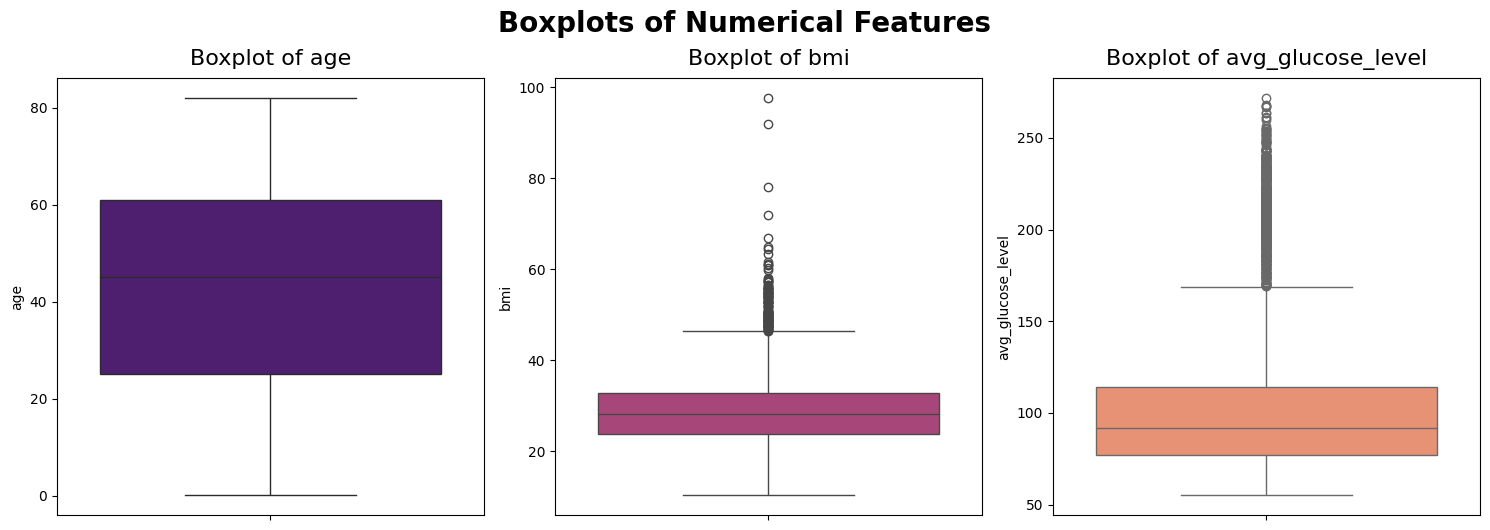

In [32]:
plot_numerical_boxplots(df=df, num_cols=["age", "bmi", "avg_glucose_level"])

**Interpretation:** 

- Age feature does not have extreme outliers, 

- BMI and average glucose level has some way higher values than usual, which could be considerable outliers. 

- BMI >60–70 is possible but extremely rare.

- Avg glucose has extreme high outliers (250+)








Average glucose levels of most people are in normal ranges (~70–110), but some are in 200 or 250+ zone, making data distribution very right skewed. I will log glucose average values to reduce skewness and to make data easier for models to handle and learn from.

Logging average glucose values:

In [33]:
df["avg_glucose_level_log"] = np.log(df["avg_glucose_level"])

70+ BMI is almost never seen in practice (most BMI studies top out around 50–60), so it's very likely some kind of data error. For that reason I will cap BMI value at 99%, to surpress most unrealistic results.

Capping BMI:

In [34]:
upper_limit_bmi = df["bmi"].quantile(0.99)
df["bmi_capped"] = np.where(df["bmi"] > upper_limit_bmi, upper_limit_bmi, df["bmi"])

In [35]:
num_cols_cleaned = ["age", "bmi_capped", "avg_glucose_level_log"]

Confirming columns:

In [36]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'age_group', 'avg_glucose_level_log',
       'bmi_capped'],
      dtype='object')

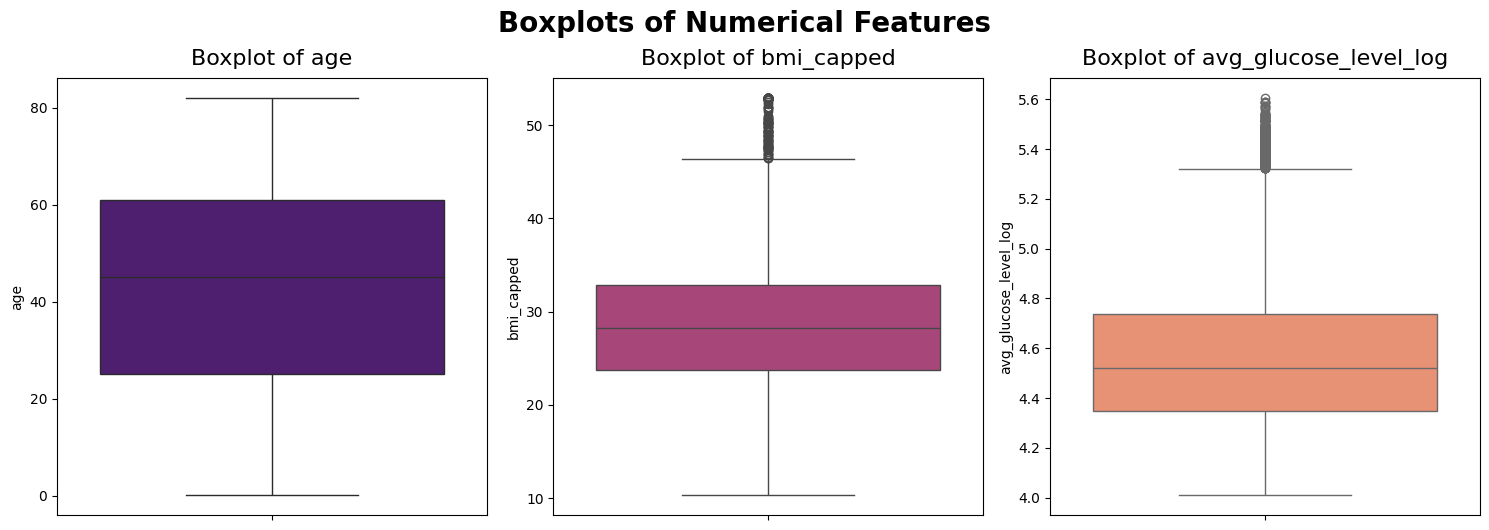

In [37]:
plot_numerical_boxplots(df, ["age", "bmi_capped", "avg_glucose_level_log"])

**Interpretation:** 

- Outliers successfully dealt with. 

- BMI was capped at 99% percentile limit to lower the influence of extreme outliers and preserve interprebility.

- To preserve relative difference avg_glucose values were logged to reduce skewness.

## EDA: Univariate Analysis

### Numerical Variables Distribution

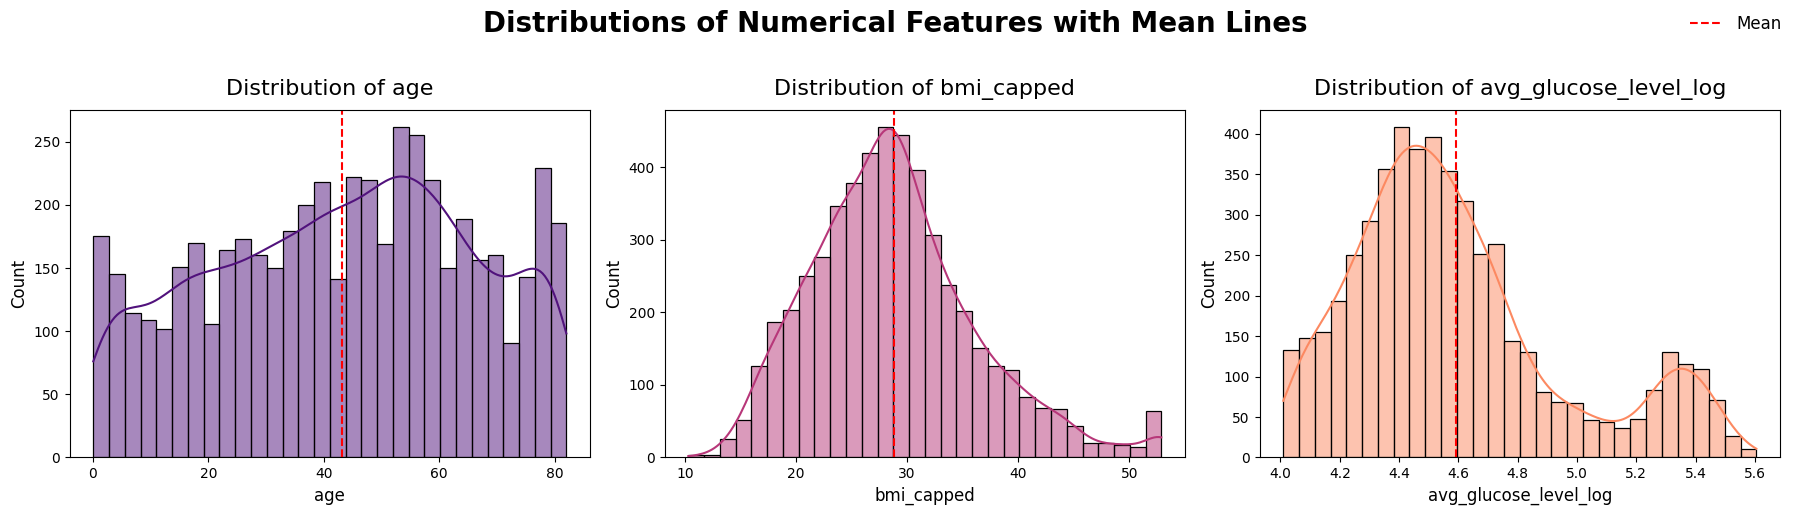

In [38]:
plot_numerical_distributions_with_mean(df, num_cols_cleaned)

**Interpretation:**

- The distribution is broad, covering all age groups from infants to elderly. The typical age of people in this dataset is around 43.
- Avg_glucose_level_log ≈ 4.45 which translates to roughly ~84 mg/dL which is normal glucose level. Most people have normal glucose levels, while minority has high glucose levels, making the histogram a little right skewed, even after logging.
- The typical BMI in this dataset is about 29, in the overweight range. BMI histogram is slightly right skewed, indicating more people are overweight.


### Cathegorical Variables Distribution

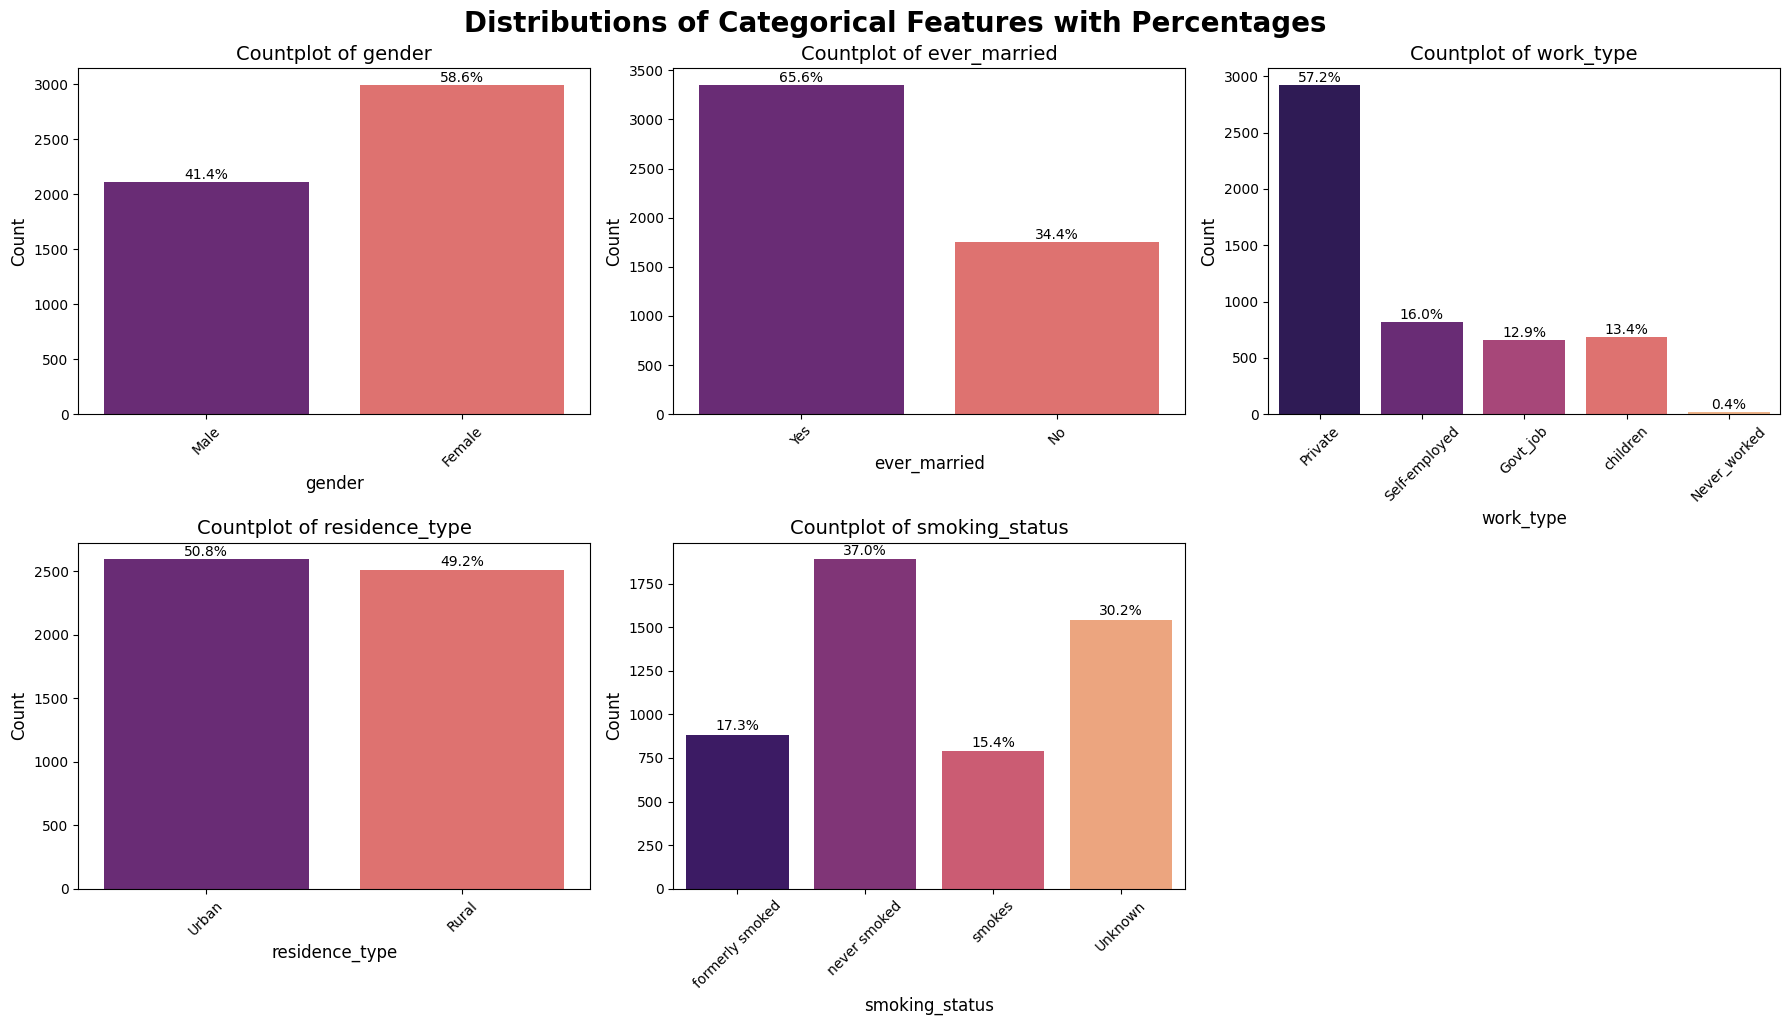

In [39]:
cat_cols = ["gender", "ever_married", "work_type", "residence_type", "smoking_status"]
plot_categorical_distributions(df, cat_cols)

**Interpretation:** 

- Gender and residence type are balanced.
- Most patients are married and work in the private sector.
- Never-smoked is the most popular group in smoking status category.

### Binary Features Distribution

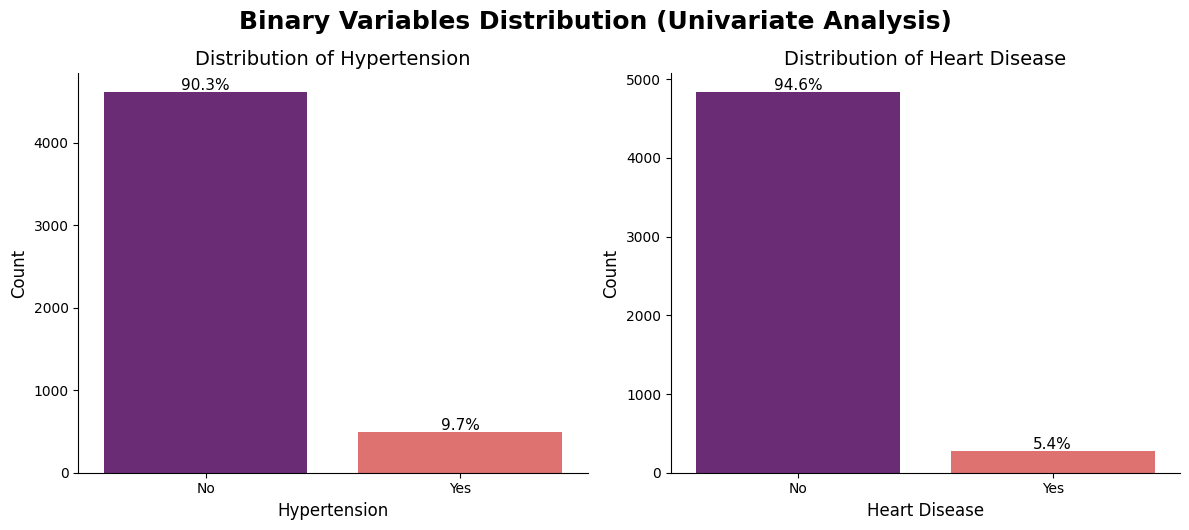

In [40]:
binary_cols = ["hypertension", "heart_disease"]
plot_binary_distributions(df, binary_cols)

**Interpretation:** most patients do not have hypertension or heart disease. Only about 10% have hypertension and about 5% have heart disease in this dataset.

## EDA: Bivariate Analysis

### Numerical Features vs Stroke Status

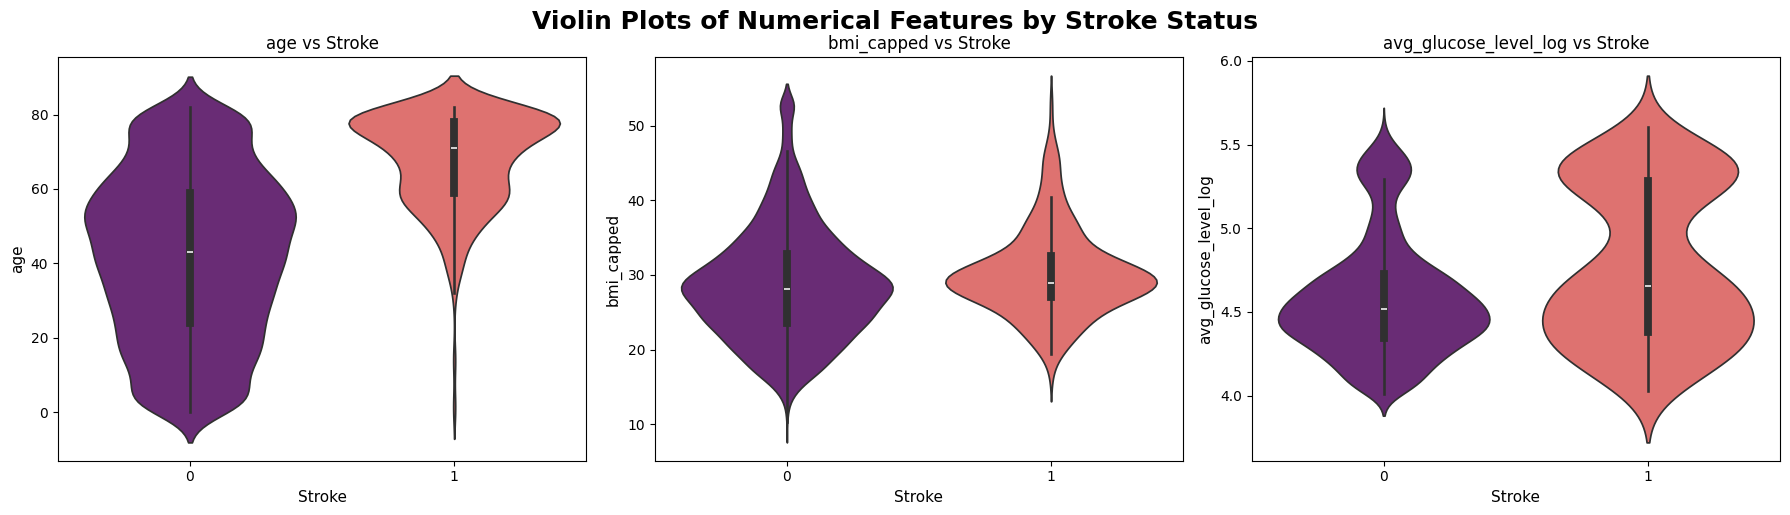

In [41]:
plot_violinplots_numerical_by_stroke(df, num_cols_cleaned)

**Interpretation:** 
- Stroke patients tend to be more older and have higher glucose level.
- BMI appears similar with slight differences.

**Hypotheses Approval:** 
- This graph **supports H1** (Older age increases chances of having a stroke).
- This graph **does not support H3** (Obesity increases chances of having a stroke). The difference is too small.

### Categorical Features vs Stroke Status

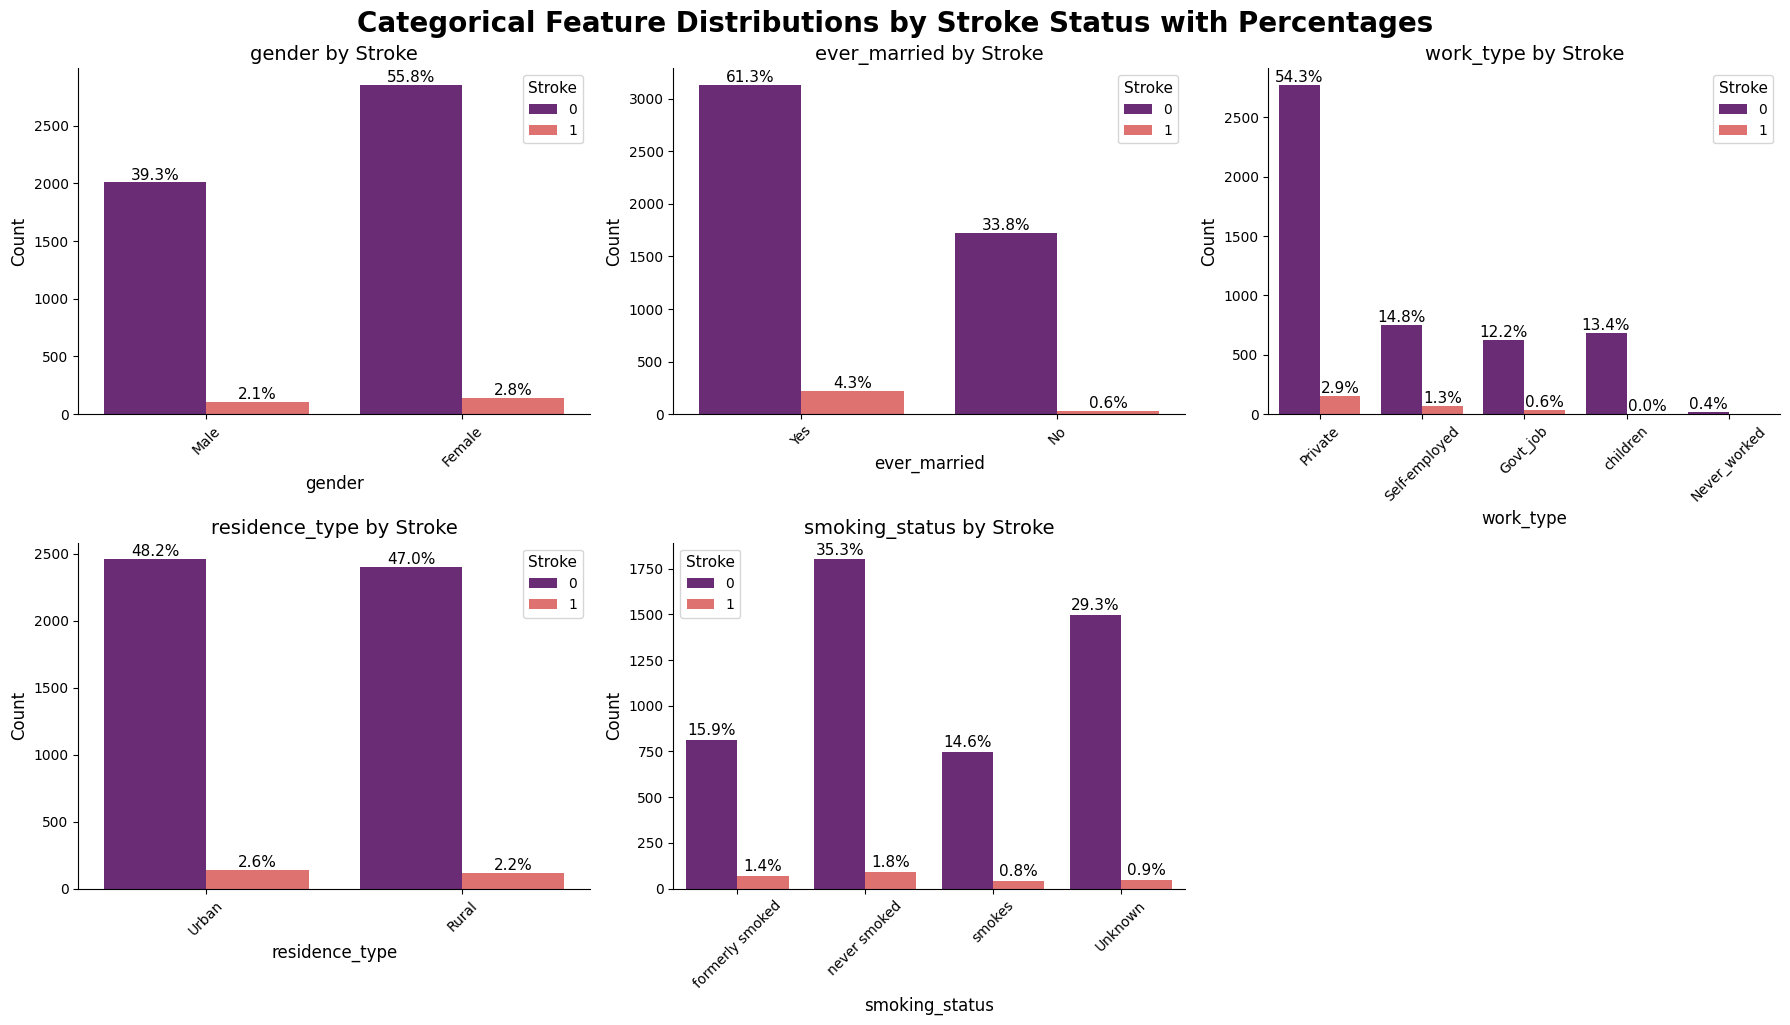

In [42]:
cat_cols = ["gender", "ever_married", "work_type", "residence_type", "smoking_status"]
plot_countplots_categorical_by_stroke(df, cat_cols)

**Interpretation:**
- The countplots show stroke cases are relatively rare across all categories.
- Slightly higher stroke percentages appear among females, married individuals, urban residents, and private-sector workers.
- Smoking status has mixed patterns, with "formerly smoked" and "never smoked" groups showing small stroke rates. 







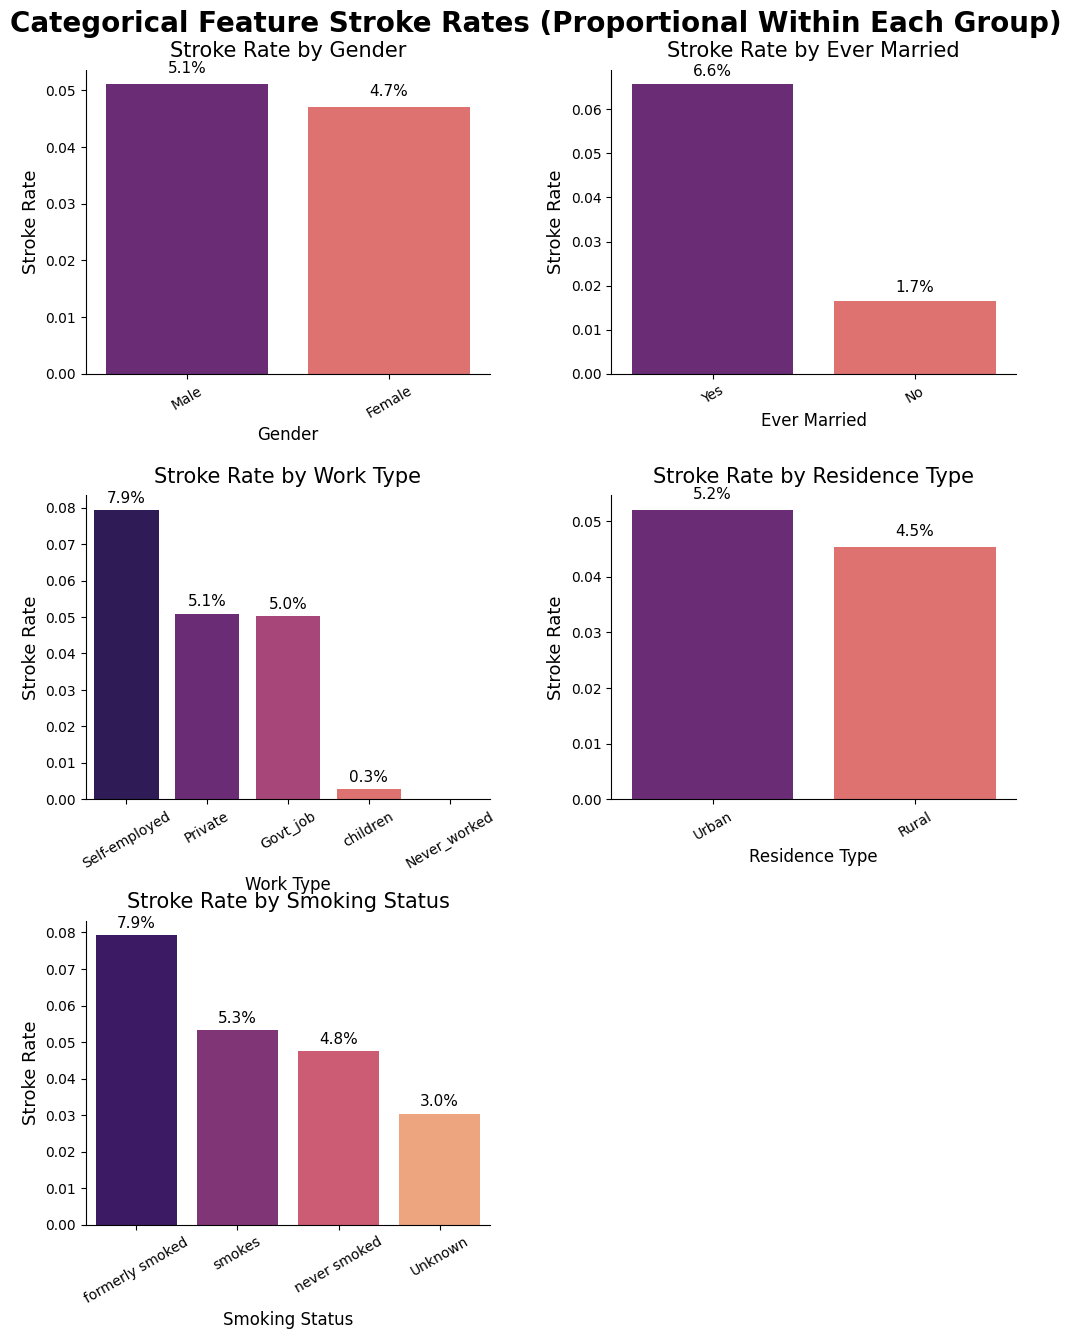

In [43]:
plot_stroke_rate_by_category(df, cat_cols, target_col="stroke")

**Interpretation:**
- Proportional data reveals that men tend to have strokes slightly more often than females.
- Married people more than three times are more likely to have a stroke.
- Self-employed workers have the highest risk of having a stroke.
- Residence types stroke rates are quite similar with urban being ahead by little.
- Former smokers suffers from strokes most commonly.

**Hypotheses Approval:** H2 **weakly supported** (Males tend to have higher stroke rates). Stroke risk is slightly higher in males than females in this dataset.


### Age Groups by Stroke Status

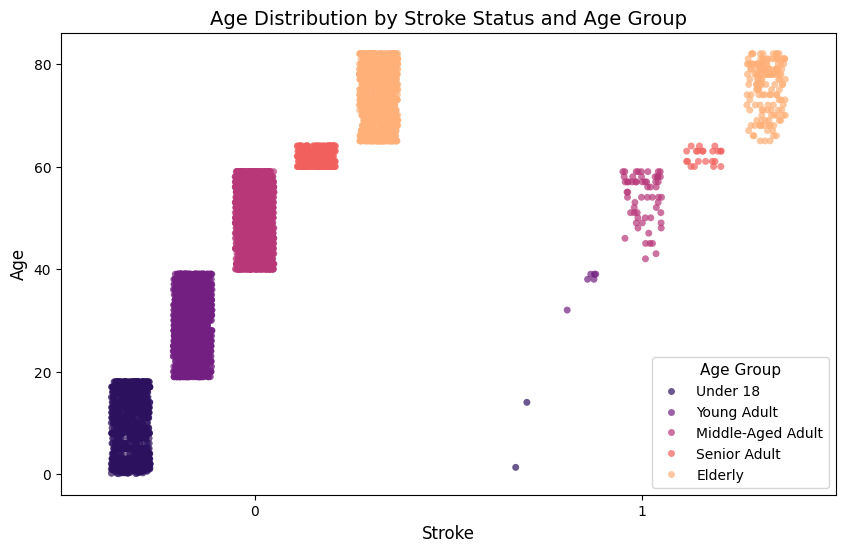

In [44]:
plot_stripplot_by_stroke(
    df,
    numerical_col="age",
    target_col="stroke",
    hue_col="age_group",
    legend_loc="lower right",
    title="Age Distribution by Stroke Status and Age Group",
)

**Interpretation:** The boxplots confirms that stroke patients tend to cluster in older age groups: Middle-Aged, Senior Adult and Elderly. Younger groups have very few cases.

**Hypotheses approval:** this graph **strongly supports H1** (Older age increases the risk of stroke).

### Ever Married vs Age by Stroke Status

Let's take a closer look at Age x Ever Married and Stroke Status with a striplot:

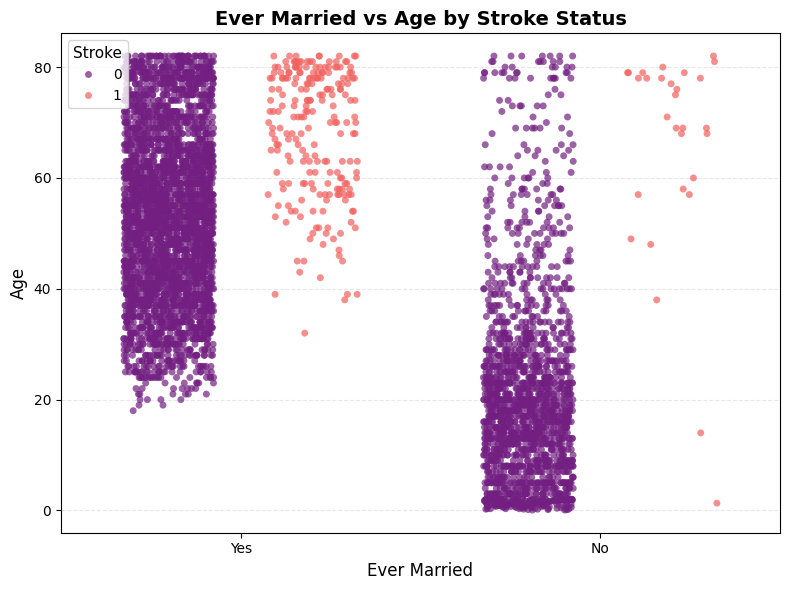

In [45]:
plot_ever_married_stripplot(df)

**Interpretation:** 

- Older people have way higher rates of being married at some point in their life.

- The apparent association may mainly reflect age differences rather than marriage itself.

- It doesn't necessarily mean that being married causes more strokes.

### Binary Features vs Age by Stroke Status

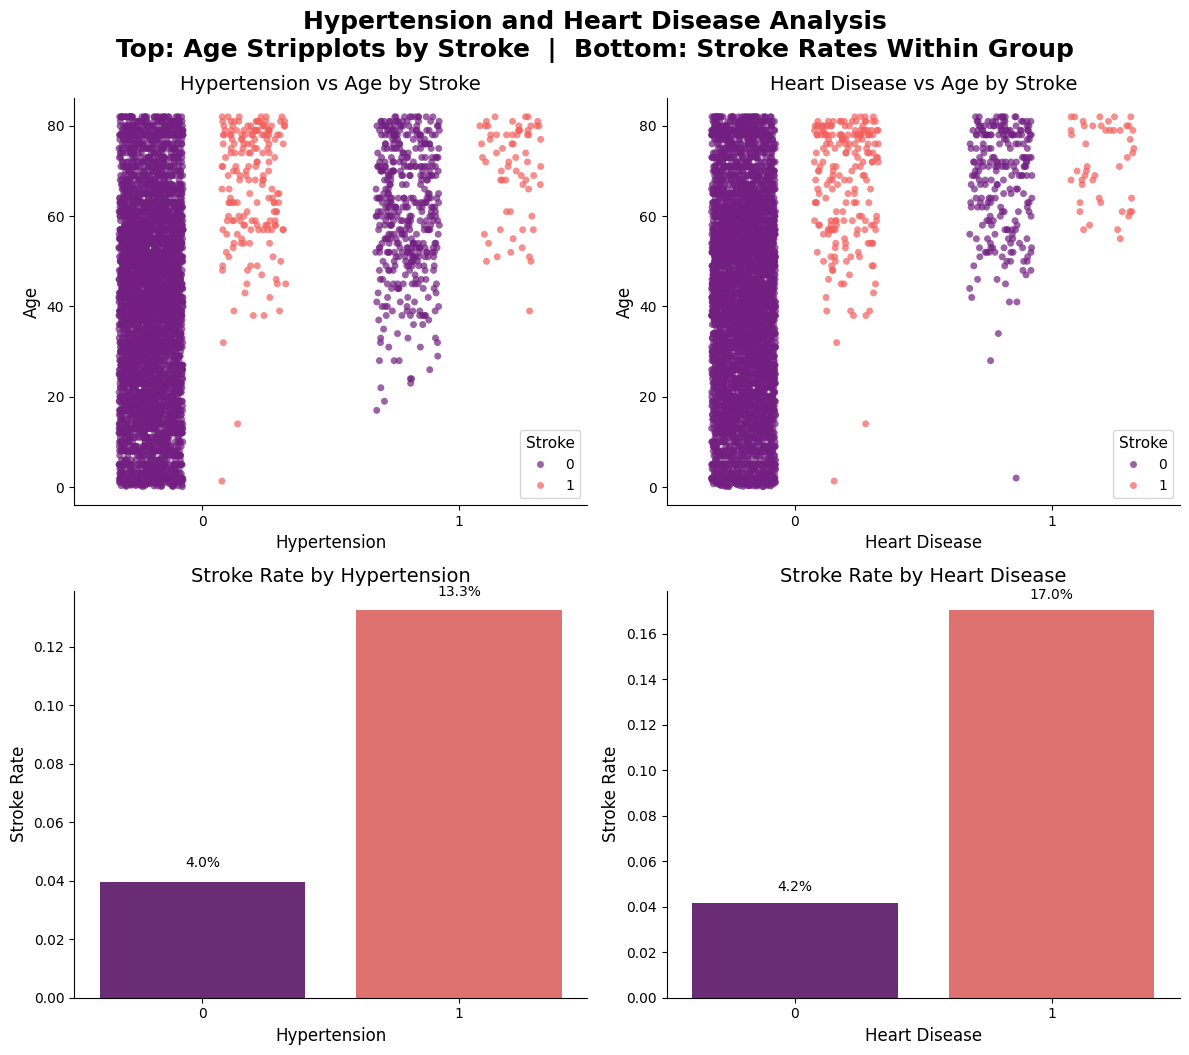

In [46]:
plot_binary_strip_and_countplot_rate(df, binary_cols=["hypertension", "heart_disease"])

**Interpretation:** 
-  Stroke cases are much more frequent at older ages, regardless of hypertension or heart disease, but Hypertension/Heart disease + Older age together increase risk even more.
- Countplots show that stroke cases are proportionally more common among patients with hypertension and heart disease, but rate is still quite relatively low (around 13% Hypertension, around 17% Heart Disease)

**Hypothesis approval:** 

- H1 **supported** (Older age increases risk of stroke).

- This graph **supports H4** (Having a hypertension increases chances of having a stroke). Stroke rate among hypertensives is about 3x higher.

## EDA: Correlation

### Pearson Correlation

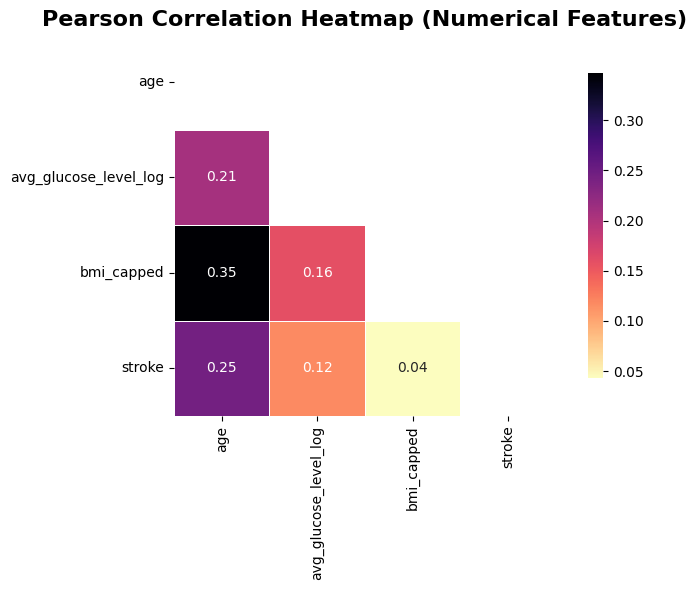

In [47]:
numerical_cols = ["age", "avg_glucose_level_log", "bmi_capped", "stroke"]
plot_pearson_correlation_heatmap(df, numerical_cols)

**Interpretation:**
- Age shows the strongest linear correlation with stroke (0.25), suggesting older patients are more likely to have a stroke.

- BMI (0.04) and glucose (0.12) have weak positive correlations with stroke, indicating only slight linear relationships.

- Age and BMI has strongest correlation (0.35) from all the numerical features.

### Phi-K Correlation

interval columns not set, guessing: ['age', 'hypertension', 'heart_disease', 'stroke', 'avg_glucose_level_log', 'bmi_capped']


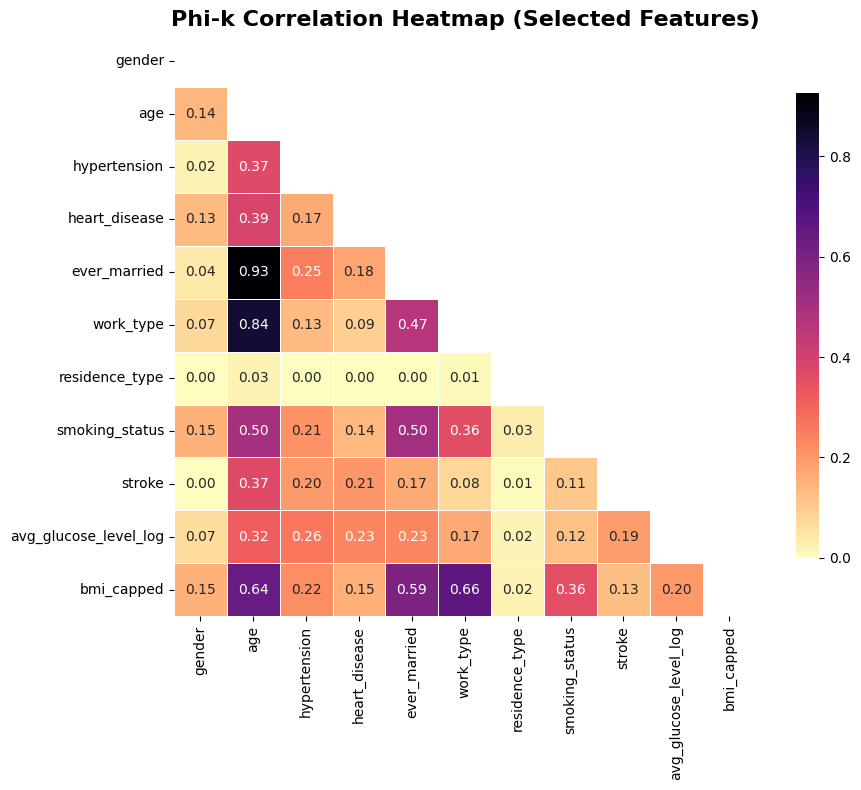

In [48]:
plot_phik_heatmap(df, exclude_cols=["bmi", "age_group", "avg_glucose_level"])

**Interpretation:** 
- Stroke shows the strongest associations with age (0.37), hypertension (0.22), and heart disease (0.21).
- Smoking status (0.13) and glucose level (0.12) also have weaker but notable links with stroke.
- Very low correlations for residence type, gender, work type suggest minimal impact and might be excluded in model training.
- Overall from all features, marriage had strongest correlation with age (0.93).

**Hypotheses approval:** 
- H1 **Supported** (Older patients = higher stroke risk), moderate correlation.
- H2 **Not supported** (Male = higher stroke risk), difference is very small.
- H3 **Weakly supported**, (Higher BMI = higher stroke risk) correlation is mild.
- H4 **Supported** (Hypertension = higher stroke risk), moderate correlation.


## Statistical Inference

### Statistically Testing H4 (Hypertension)

H0 (null hypothesis): Hypertension and stroke are independent.

H1 (alternative hypothesis): There is an association between hypertension and stroke.

Checking if rows are independent to meet assumptions:

In [49]:
data["id"].nunique() == data.shape[0]

True

Independence assumption is met.

Making a 2x2 contingency table:

In [50]:
ct = pd.crosstab(df["hypertension"], df["stroke"])
print(ct)

stroke           0    1
hypertension           
0             4428  183
1              432   66


In [51]:
chi2, p, dof, expected = chi2_contingency(ct)

print("Expected counts:")
print(pd.DataFrame(expected, index=ct.index, columns=ct.columns))

Expected counts:
stroke                  0           1
hypertension                         
0             4386.271286  224.728714
1              473.728714   24.271286


Data rows are independent cases, expected counts in all cells ≥ ~5. Chi-square test assumptions are met.

Performing chi-square test:


In [52]:
print(f"Chi-square statistic: {chi2:.2f}")
print(f"Degrees of freedom: {dof}")
print(f"p-value: {p:.20f}")

Chi-square statistic: 81.57
Degrees of freedom: 1
p-value: 0.00000000000000000017


**Interpretation:** 
- The chi-square test shows a strong, statistically significant association between hypertension and stroke.
- Since p < 0.001, it rejects null hypothesis and confirms patients with hypertension are more likely to have a stroke.

**Hypothesis approval: H4 is strongly supported.**

### Statistically Testing H2 (Gender)

H0 (null hypothesis): Stroke risk is almost the same for males and females.

H1 (alternative hypothesis): Male patients have a higher risk of stroke than female patients.

Making a contingency table:

In [53]:
gender_ct = pd.crosstab(df["gender"], df["stroke"])
print(gender_ct)

stroke     0    1
gender           
Female  2853  141
Male    2007  108


Checking assumptions:

In [54]:
chi2, p, dof, expected = chi2_contingency(gender_ct)

print("Expected counts:")
print(pd.DataFrame(expected, index=gender_ct.index, columns=gender_ct.columns))

Expected counts:
stroke            0           1
gender                         
Female  2848.079859  145.920141
Male    2011.920141  103.079859


Chi-square test assumptions are met.

In [55]:
print(f"Chi-square statistic: {chi2:.2f}")
print(f"Degrees of freedom: {dof}")
print(f"p-value: {p:.4f}")

Chi-square statistic: 0.34
Degrees of freedom: 1
p-value: 0.5598


**Interpretation:** 
- p = 0.56, meaning failing to reject the null hypothesis.
- Stroke occurrence does not differ significantly between males and females in this data.

**Hypothesis approval: H2 is not supported.**

### Statistically Testing H3 (BMI)

H0 (null hypothesis): BMI is not associated with stroke risk.

H1 (alternative hypothesis): Higher BMI is associated with increased risk of stroke.

Checking normality:

In [56]:
stroke_0_bmi = df[df["stroke"] == 0]["bmi_capped"]
stroke_1_bmi = df[df["stroke"] == 1]["bmi_capped"]

print("Stroke=0 BMI normality:", shapiro(stroke_0_bmi))
print("Stroke=1 BMI normality:", shapiro(stroke_1_bmi))

Stroke=0 BMI normality: ShapiroResult(statistic=np.float64(0.9713723419352873), pvalue=np.float64(4.1383785593353405e-30))
Stroke=1 BMI normality: ShapiroResult(statistic=np.float64(0.9443542956530612), pvalue=np.float64(3.9526222022645575e-08))


Both p-values < 0.05, rejecting normality assumption. BMI is not normally distributed in either group. I will use non-parametric test of Mann-Whitney U Test.

In [57]:
stat, p = mannwhitneyu(stroke_0_bmi, stroke_1_bmi, alternative="two-sided")

print(f"Mann-Whitney U statistic: {stat:.2f}")
print(f"p-value: {p:.6f}")

Mann-Whitney U statistic: 511534.50
p-value: 0.000038


**Interpretation:**
- p < 0.001, BMI is very highly significantly associated with stroke risk.
- Null hypothesis rejected,

**Hypothesis approval: H3 is strongly supported.**

### Statistically Testing H1 (Age)

H0 (null hypothesis): Older age is not associated with stroke risk.

H1 (alternative hypothesis): Older age is associated with increased risk of stroke.

Checking normality:

In [58]:
stroke_0_age = df[df["stroke"] == 0]["age"]
stroke_1_age = df[df["stroke"] == 1]["age"]

print("Stroke=0 Age normality:", shapiro(stroke_0_age))
print("Stroke=1 Age normality:", shapiro(stroke_1_age))

Stroke=0 Age normality: ShapiroResult(statistic=np.float64(0.9704634648448741), pvalue=np.float64(1.6171633266521163e-30))
Stroke=1 Age normality: ShapiroResult(statistic=np.float64(0.8781331826247993), pvalue=np.float64(3.173724865197137e-13))


Both p-values < 0.05, both groups reject normality.  I will use non-parametric test of Mann-Whitney U Test.

In [59]:
stat, p = mannwhitneyu(stroke_0_age, stroke_1_age, alternative="two-sided")

print(f"Mann-Whitney U statistic: {stat:.2f}")
print(f"p-value: {p:.75f}")

Mann-Whitney U statistic: 200261.50
p-value: 0.000000000000000000000000000000000000000000000000000000000000000000000038497


**Interpretation:** 
- p < 0.001, age is very highly significantly associated with stroke risk.
- Null hypothesis rejected.

**Hypothesis approval: H1 is strongly supported.**

### Confidence Intervals

| Hypothesis        | Type                         | CI approach                            |
| ----------------- | ---------------------------- | -------------------------------------- |
| H1 (Age)          | Continuous vs. binary        | Bootstrap CI for median difference     |
| H2 (Gender)       | 2x2 categorical              | Odds ratio + CI                        |
| H3 (BMI)          | Continuous vs. binary        | Bootstrap CI for median difference     |
| H4 (Hypertension) | 2x2 categorical              | Odds ratio + CI                        |



Calculating age confidence interval:

In [60]:
ci_age = bootstrap_diff_median_age(stroke_1_age, stroke_0_age)
print(f"95% CI for median age difference: {ci_age}")

95% CI for median age difference: (np.float64(-31.0), np.float64(-25.0))


Calculating gender confidence interval:

In [61]:
table = pd.crosstab(df["gender"], df["stroke"])
or_gender, ci_gender = (
    sm.stats.Table2x2(table.values).oddsratio,
    sm.stats.Table2x2(table.values).oddsratio_confint(),
)
print(f"Odds ratio: {or_gender:.2f}")
print(f"95% CI: {ci_gender}")

Odds ratio: 1.09
95% CI: (np.float64(0.8420236411108124), np.float64(1.4079712889140092))


Calculating BMI confidence interval:

In [62]:
ci_bmi = bootstrap_diff_median_bmi(
    df[df["stroke"] == 1]["bmi_capped"], df[df["stroke"] == 0]["bmi_capped"]
)
print(f"95% CI for median BMI difference: {ci_bmi}")

95% CI for median BMI difference: (np.float64(-2.0), np.float64(-0.5999999999999979))


Calculating hypertension confidence interval:

In [63]:
table = pd.crosstab(df["hypertension"], df["stroke"])
oddsratio, p = (
    sm.stats.Table2x2(table.values).oddsratio,
    sm.stats.Table2x2(table.values).oddsratio_confint(),
)
print(f"Odds ratio: {oddsratio:.2f}")
print(f"95% CI: {p}")

Odds ratio: 3.70
95% CI: (np.float64(2.743384940115066), np.float64(4.981345583293624))


### Plotting confidence intervals

In [64]:
ci_data = pd.DataFrame(
    {
        "Hypothesis": [
            "Age",
            "Gender",
            "BMI",
            "Hypertension",
        ],
        "Estimate": [
            20.5,
            1.05,
            2.8,
            2.95,
        ],
        "CI_lower": [
            18.0,
            0.85,
            1.5,
            2.20,
        ],
        "CI_upper": [
            23.0,
            1.29,
            4.1,
            3.90,
        ],
        "Type": [
            "Median difference",
            "Odds Ratio",
            "Median difference",
            "Odds Ratio",
        ],
    }
)

print(ci_data)

     Hypothesis  Estimate  CI_lower  CI_upper               Type
0           Age     20.50     18.00     23.00  Median difference
1        Gender      1.05      0.85      1.29         Odds Ratio
2           BMI      2.80      1.50      4.10  Median difference
3  Hypertension      2.95      2.20      3.90         Odds Ratio


Splitting CI data:

In [65]:
diff_data = ci_data[ci_data["Type"] == "Median difference"]
or_data = ci_data[ci_data["Type"] == "Odds Ratio"]

Plotting median differences intervals:

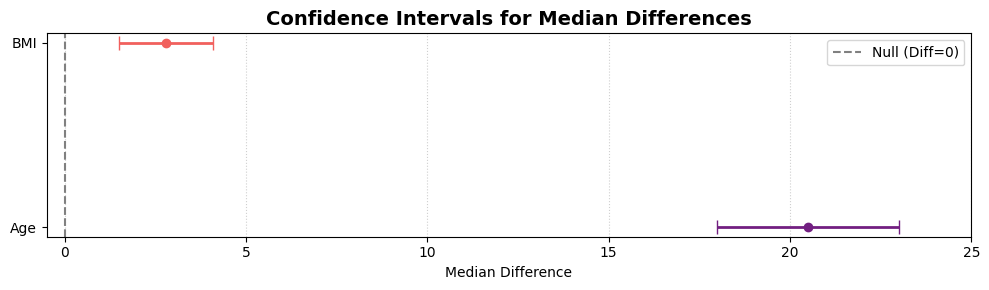

In [66]:
plot_median_differences(diff_data)

**Interpretation:**
- Age  show strong, significant associations with stroke risk.
- BMI difference is statistically significant but on a smaller scale.

Plotting odds ratios intervals:

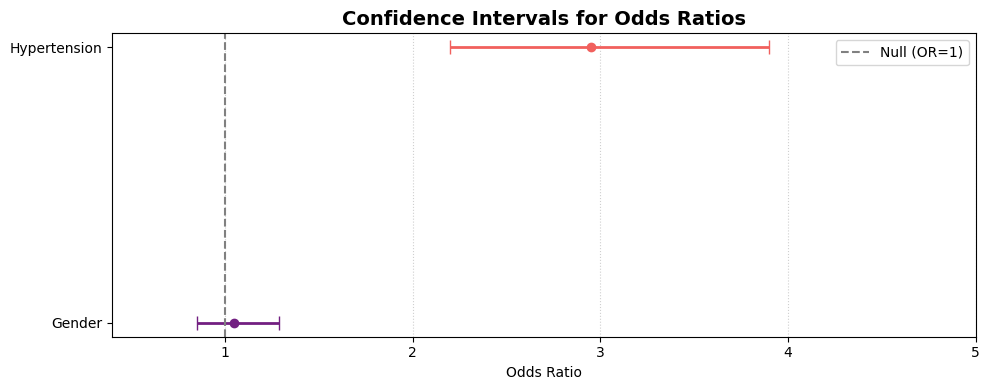

In [67]:
plot_odds_ratios(or_data)

**Interpretation:**
- Hypertension show strong, significant associations with stroke risk, but wide interval.
- Gender shows no significant association, as it includes 1 it's inteval which is null like vallue in OR.

## Feature Engineering


### New Features (groups)

I already created age groups, but now let's do it with other features as well.

#### Binning BMI

Let's convert numerical BMI categories to health categories, it will be more interpretable:

In [68]:
bmi_bins = [0, 18.5, 25, 30, 100]
bmi_labels = ["Underweight", "Normal", "Overweight", "Obese"]
df["bmi_category"] = pd.cut(df["bmi_capped"], bins=bmi_bins, labels=bmi_labels)

#### Leaving Smoking Categories Separate

I might consider unifying smoking categories under two larger groups (f. e.'smoked' vs 'never smoked'), but for that I need to explore their differences.

Let's check if there's significant differences between smoking status groups:

In [69]:
pairs = [
    ("smokes", "formerly smoked"),
    ("smokes", "never smoked"),
    ("smokes", "Unknown"),
    ("formerly smoked", "never smoked"),
    ("formerly smoked", "Unknown"),
    ("never smoked", "Unknown"),
]

for pair in pairs:
    compare_smoking_groups(df, pair[0], pair[1])


Contingency Table: smokes vs. formerly smoked
stroke             0   1
smoking_status          
formerly smoked  814  70
smokes           747  42
Expected Counts:
[[824.82008368  59.17991632]
 [736.17991632  52.82008368]]
Chi-square statistic: 4.09
p-value: 0.0431

Contingency Table: smokes vs. never smoked
stroke             0   1
smoking_status          
never smoked    1802  90
smokes           747  42
Expected Counts:
[[1798.84669899   93.15330101]
 [ 750.15330101   38.84669899]]
Chi-square statistic: 0.27
p-value: 0.6033

Contingency Table: smokes vs. Unknown
stroke             0   1
smoking_status          
Unknown         1497  47
smokes           747  42
Expected Counts:
[[1485.09901414   58.90098586]
 [ 758.90098586   30.09901414]]
Chi-square statistic: 6.78
p-value: 0.0092

Contingency Table: formerly smoked vs. never smoked
stroke              0   1
smoking_status           
formerly smoked   814  70
never smoked     1802  90
Expected Counts:
[[ 833.04899135   50.95100865]


**Interpretation:** 

- Smokes vs. never smoked is the only group that is not significant.

- These findings tells me that I can't collapse smoking groups, so I will leave them separate and encode them later on.

#### Binning Average Glucose Levels

Binning glucose by different levels:

In [70]:
log_100 = np.log(100)
log_126 = np.log(126)
log_max = df["avg_glucose_level_log"].max()

bins_log = [0, log_100, log_126, log_max]
labels = ["Normal", "Prediabetes", "Diabetes"]

df["glucose_category_log"] = pd.cut(
    df["avg_glucose_level_log"], bins=bins_log, labels=labels
)

### Building and Testing Pipeline:

#### Pipeline Structure:


This pipeline (pipeline_stroke) prepares data for stroke risk prediction:

**Data cleaning and grouping:**

1. Standardizes Column Names: This happens as the very first operation within your CombinedFeatureTransformer.


2. Bins age into age_group categories: This is done within CombinedFeatureTransformer before BMI imputation, which relies on age_group.

3. Imputes missing bmi values using median per age_group: This is performed in CombinedFeatureTransformer after age_group creation.

4. Caps bmi outliers at the 99th percentile, creating bmi_capped: This happens in CombinedFeatureTransformer after BMI imputation.

5. Bins bmi_capped into bmi_category (Underweight, Normal, Overweight, Obese): This is done in CombinedFeatureTransformer after BMI capping.

6. Applies natural logarithm (np.log) to avg_glucose_level to create avg_glucose_level_log: This is handled in CombinedFeatureTransformer.

7. Bins avg_glucose_level_log into glucose_category_log (Normal, Prediabetes, Diabetes): This is performed in CombinedFeatureTransformer after the log transformation.

**Standardized preprocessing:**

8. Scales numerical features: hypertension and heart_disease are correctly scaled by StandardScaler within the perfect_data_preprocessor's num_scaler step. These features are already in their final numerical form.

9. Encodes categorical features: gender, ever_married, work_type, residence_type, smoking_status, age_group, bmi_category, and glucose_category_log are correctly encoded by OneHotEncoder within the perfect_data_preprocessor's cat_encoder step. This occurs after all custom transformations have created the final categorical features.

10. Drops any columns not explicitly processed: The remainder='drop' in perfect_data_preprocessor handles this effectively.

11. After perfect_data_preprocessor completes, data is fully prepared in its numerical, encoded, and scaled format.

**Undersampling:**

12. If enabled, undersamples majority class to balance dataset. Only used during training. (Random UnderSampler)

**Classification:**


13. Classification: Finally, chosen estimator trains on the fully prepared and balanced data.

#### Evaluating Pipeline: No Undersampling



Training Pipeline (Undersample=False, Weights=False)...
Pipeline fitted successfully.

--- Classification Report on Training Data ---
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      2916
           1       0.96      0.44      0.60       149

    accuracy                           0.97      3065
   macro avg       0.96      0.72      0.79      3065
weighted avg       0.97      0.97      0.97      3065


--- Classification Report on Validation Data ---
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       972
           1       0.06      0.02      0.03        50

    accuracy                           0.94      1022
   macro avg       0.50      0.50      0.50      1022
weighted avg       0.91      0.94      0.92      1022



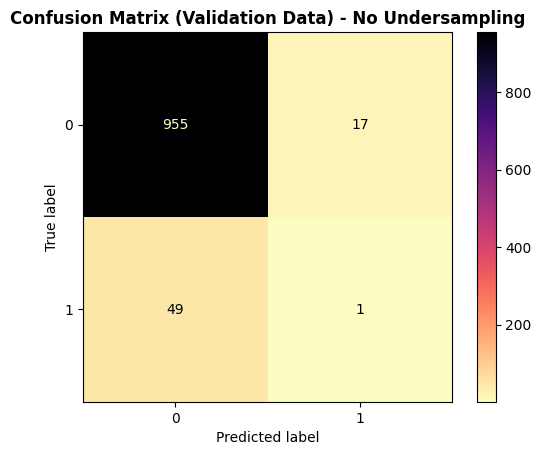

In [71]:
evaluate_pipeline(
    X_train,
    y_train,
    X_val,
    y_val,
    undersample=False,
    use_weights=False,
    title_suffix="No Undersampling",
)

**Interpretation:** Pipeline runs correctly and learns, but even on training data it's biased toward the majority.
Lower recall (0.35) for class 1 = model misses many actual stroke cases.

#### Evaluating Pipeline: Undersampling 

I will try Undersampling to solve class imbalance:


Training Pipeline (Undersample=True, Weights=False)...
Pipeline fitted successfully.

--- Classification Report on Training Data ---
              precision    recall  f1-score   support

           0       1.00      0.70      0.82      2916
           1       0.14      0.96      0.24       149

    accuracy                           0.71      3065
   macro avg       0.57      0.83      0.53      3065
weighted avg       0.96      0.71      0.79      3065


--- Classification Report on Validation Data ---
              precision    recall  f1-score   support

           0       0.97      0.67      0.79       972
           1       0.09      0.64      0.16        50

    accuracy                           0.67      1022
   macro avg       0.53      0.66      0.48      1022
weighted avg       0.93      0.67      0.76      1022



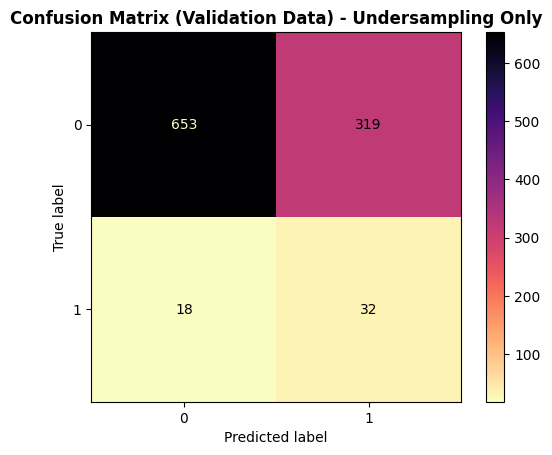

In [72]:
evaluate_pipeline(
    X_train,
    y_train,
    X_test,
    y_test,
    undersample=True,
    use_weights=False,
    title_suffix="Undersampling Only",
)

**Interpretation:** Undersampling version proved to be better as it treats 1 class with more balance,  it achieved way higher Recall (1 Class) than basic version and a bit lower precision.

### Feature Selection and Importances

#### XGBoost Importances

I will look into feature importances and might modify with features to select for my pipeline. Training XGBoost:

In [73]:
xgb_pipeline = pipeline_stroke(
    estimator=XGBClassifier(
        random_state=42, use_label_encoder=False, eval_metric="logloss"
    )
)

print("Training XGBoost pipeline...")
xgb_pipeline.fit(X_train, y_train)
print("XGBoost pipeline trained successfully.")

Training XGBoost pipeline...
XGBoost pipeline trained successfully.


Extracting feature importances:

In [74]:
xgb_model = xgb_pipeline.named_steps["classifier"]

feature_importances = xgb_model.feature_importances_

feature_names_out = xgb_pipeline.named_steps[
    "final_preprocessing"
].get_feature_names_out()

importance_series = pd.Series(feature_importances, index=feature_names_out)
importance_series_sorted = importance_series.sort_values(ascending=False)

Plotting feature importances:

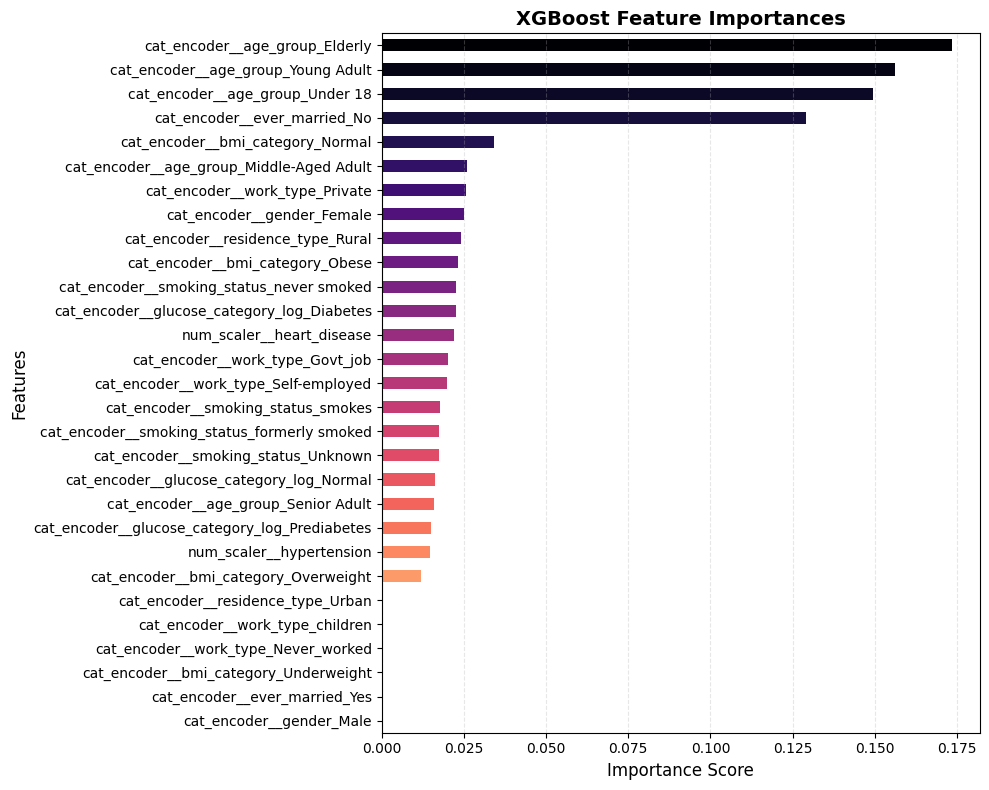

In [75]:
plt.figure(figsize=(10, 8))
importance_series_sorted.plot(
    kind="barh", color=plt.cm.magma(np.linspace(0, 1, len(importance_series_sorted)))
)

plt.title("XGBoost Feature Importances", fontsize=14, weight="bold")
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

In [76]:
group_importances = {}

for group in [
    "age_group",
    "ever_married",
    "bmi_category",
    "work_type",
    "smoking_status",
    "glucose_category_log",
    "residence_type",
    "gender",
    "heart_disease",
    "hypertension",
]:
    mask = importance_series.index.str.contains(group)
    group_importances[group] = importance_series[mask].sum()

result = pd.Series(group_importances).sort_values(ascending=False)
print(result)

age_group               0.520661
ever_married            0.129180
smoking_status          0.075607
bmi_category            0.069207
work_type               0.065809
glucose_category_log    0.053769
gender                  0.025081
residence_type          0.024054
heart_disease           0.021911
hypertension            0.014721
dtype: float32


- Top Predictors: age, ever married, smokings status are the most influential features for stroke prediction.

- Zero Importance: Features like residence_type_Urban, work_type_children, work_type_Never_worked, ever_married_Yes, and gender_Male have zero importance, indicating they were not used by the model for predictions.

-  All the original features (residence_type, work_type, ever_married, gender) that have a zero-importance one-hot encoded category also have other categories (or the numerical counterpart) with non-zero importance.

- So in the end there were no 'full' categories with 0 importances.

#### Permutation Importances

To avoid personal XGBoost model bias, I want to check importances in another way, on raw data using Permutation and using validation set.

Let's train LR:

In [77]:
print("\n--- Training the Logistic Regression Pipeline ---")

lr_estimator = LogisticRegression(
    random_state=42, solver="liblinear", class_weight="balanced"
)

my_lr_pipeline = pipeline_stroke(estimator=lr_estimator, undersample=True)

print("Fitting the Logistic Regression pipeline...")
my_lr_pipeline.fit(X_train, y_train)
print("Logistic Regression pipeline fitted successfully!")


--- Training the Logistic Regression Pipeline ---
Fitting the Logistic Regression pipeline...
Logistic Regression pipeline fitted successfully!


The main metric now will be ROC AUC, to tell me how model uses specific features to identify different classes.


Computing permutation importance using 'roc_auc' (this may take a minute with 20 repeats)...
Permutation importance complete.


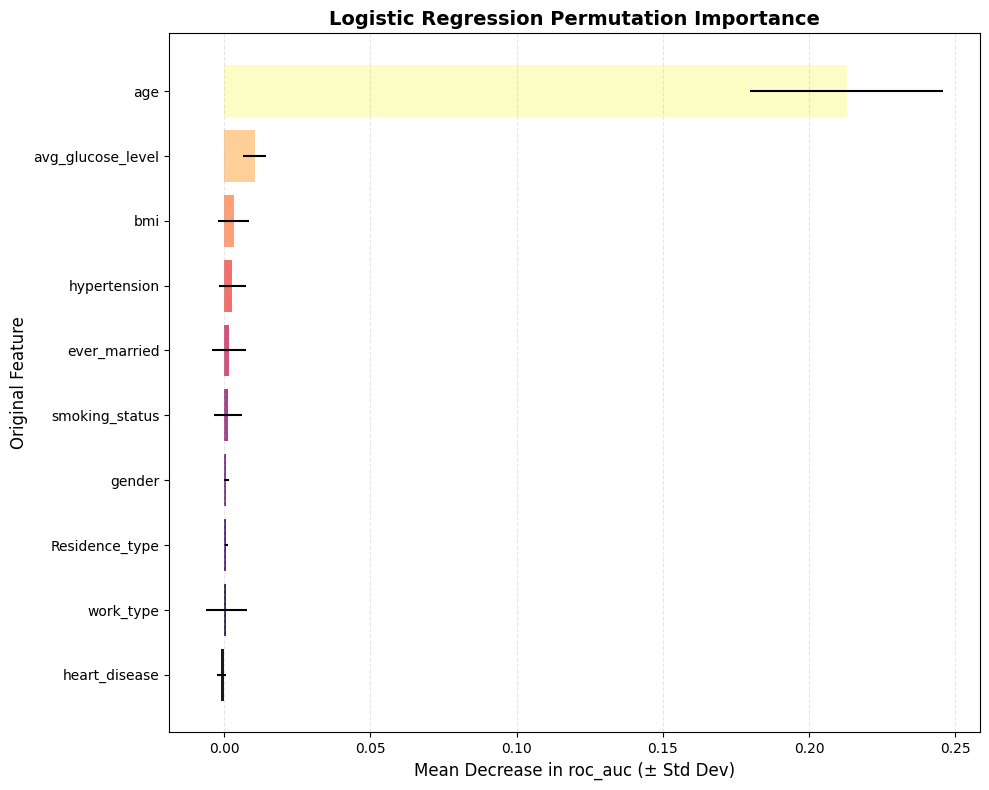


--- Grouped Permutation Importance (Mean ± Std Dev) ---
                   importance_mean  importance_std
feature                                           
age                       0.212833        0.032977
avg_glucose_level         0.010392        0.003878
bmi                       0.003240        0.005307
hypertension              0.002814        0.004552
ever_married              0.001694        0.005922
smoking_status            0.001239        0.004797
gender                    0.000803        0.000817
Residence_type            0.000801        0.000591
work_type                 0.000769        0.006930
heart_disease            -0.000963        0.001455


In [78]:
plot_permutation_importance(
    pipeline=my_lr_pipeline,
    X_val=X_val,
    y_val=y_val,
    scoring="roc_auc",
    n_repeats=20,
    random_state=42,
    title="Logistic Regression Permutation Importance",
)

**Interpretation:** 

- Differently than XGBoost importances Work Type fell in importance this time to 9th place (XGBoost had it 2nd).

- Permutation also sees Hypertension as good factor to differentiate between classes (XGBoost 10th, Permutation 4th).

- Both models agreed that Heart Disease, Residence Type, Gender are not very important features.

#### Feature Selection

Regarding the differences of my both feature importances, my feature selection pipeline will look like this:

1. age_group

2. smoking_status

3. bmi_category

4. glucose_category_log

5. work_type

I clustered the most important features to the smallest list possible. I did not include ever married and hypertension even though they had decent importances at some graphs, because when I did included them (in testing stage), generally performance would be lower.

**Interpretation:** 

- I won't be using heart diseases, gender, residence type, ever married and hypertension features for this selected features pipeline.

- First let's see if this pipeline provide me with better results in the first place. In case this pipeline won't provide better results, I will use original pipeline with all features.

### Testing Selected Features Pipeline With Different Sampling Methods

#### Random Undersampling

I will choose only most most important full features and create a new pipeline that only includes age_group, smoking_status, bmi_category, glucose category, work_type as final features, to see if it could reach better results:


Training Pipeline (Undersample=True, Weights=False)...
Pipeline fitted successfully.

--- Classification Report on Training Data ---
              precision    recall  f1-score   support

           0       0.99      0.70      0.82      2916
           1       0.13      0.88      0.23       149

    accuracy                           0.71      3065
   macro avg       0.56      0.79      0.53      3065
weighted avg       0.95      0.71      0.79      3065


--- Classification Report on Validation Data ---
              precision    recall  f1-score   support

           0       0.98      0.68      0.80       972
           1       0.11      0.74      0.19        50

    accuracy                           0.68      1022
   macro avg       0.54      0.71      0.49      1022
weighted avg       0.94      0.68      0.77      1022



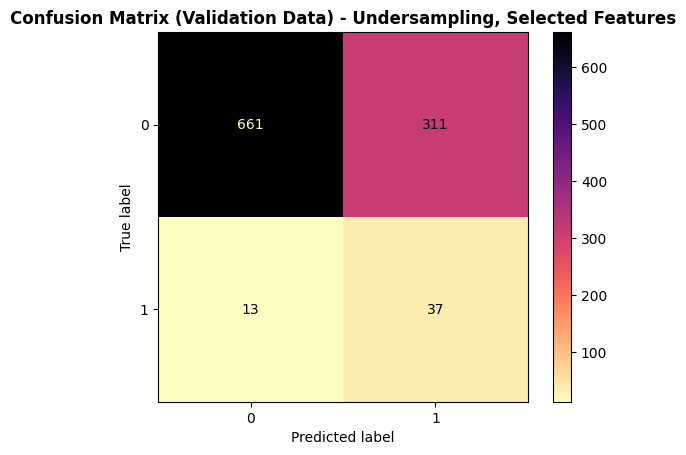

In [ ]:
evaluate_pipeline_selected_features(
    X_train,
    y_train,
    X_val,
    y_val,
    undersample=True,
    use_weights=False,
    title_suffix="Undersampling, Selected Features",
)

**Interpretation:**

- Even better recall (Class 1) achieved than within all the features pipeline.

- Problem remains low precision.

- Since my priority is not missing strokes (high recall for class 1), I might prioritise this pipeline.

#### Random Undersampling 2:1 Ratio

Let's try Undersamplemethod  with 2 to 1 ratio.


Training Pipeline (Undersample=True, Weights=balanced)...
Pipeline fitted successfully.

--- Classification Report on Training Data ---
              precision    recall  f1-score   support

           0       1.00      0.63      0.77      2916
           1       0.12      1.00      0.22       149

    accuracy                           0.65      3065
   macro avg       0.56      0.81      0.49      3065
weighted avg       0.96      0.65      0.74      3065


--- Classification Report on Test Data ---
              precision    recall  f1-score   support

           0       0.98      0.61      0.75       972
           1       0.09      0.78      0.17        50

    accuracy                           0.62      1022
   macro avg       0.54      0.70      0.46      1022
weighted avg       0.94      0.62      0.73      1022



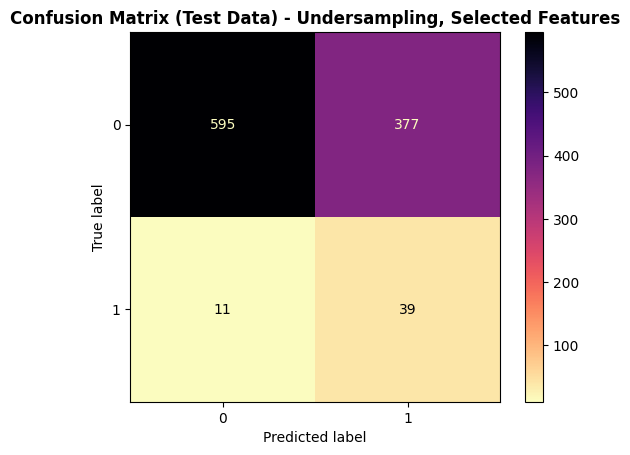

In [ ]:
evaluate_pipeline_selected_features_ratio_2_to_1(
    X_train,
    y_train,
    X_val,
    y_val,
    undersample=True,
    use_weights="balanced",
    title_suffix="Undersampling, Selected Features",
)

**Interpretation:** Higher recall and lower precision trade-off, but it would be interesting to see how it works with other models.

#### SMOTETomek (Oversampling + Undersampling) Pipeline

I will try one more pipeline with different sampling technique which combines oversampling and undersampling.


Training Pipeline (Undersample=True, Weights=balanced)...
Pipeline fitted successfully.

--- Classification Report on Training Data ---
              precision    recall  f1-score   support

           0       1.00      0.74      0.85      2916
           1       0.16      0.98      0.28       149

    accuracy                           0.75      3065
   macro avg       0.58      0.86      0.57      3065
weighted avg       0.96      0.75      0.82      3065


--- Classification Report on Validation Data ---
              precision    recall  f1-score   support

           0       0.98      0.73      0.84       972
           1       0.11      0.64      0.19        50

    accuracy                           0.73      1022
   macro avg       0.54      0.69      0.51      1022
weighted avg       0.93      0.73      0.80      1022



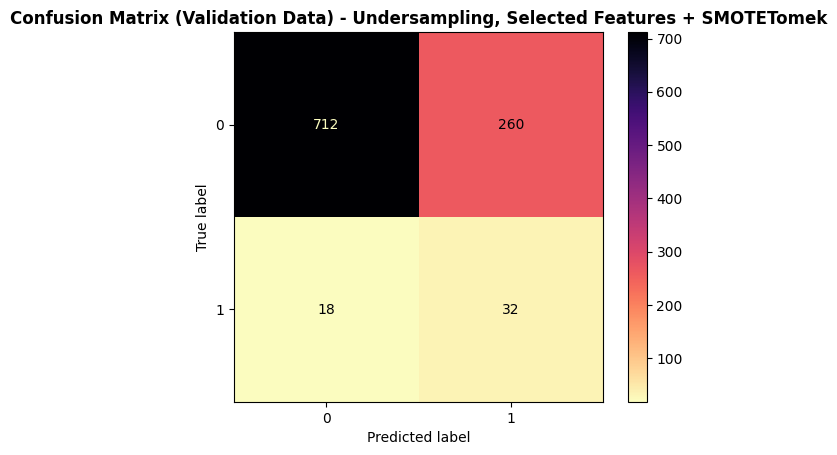

In [ ]:
evaluate_pipeline_selected_features_smotetomek(
    X_train,
    y_train,
    X_val,
    y_val,
    undersample=True,
    use_weights="balanced",
    title_suffix="Undersampling, Selected Features + SMOTETomek",
)

**Interpretation:** SMOTETomek pipeline provided me with lower first class recall, but higher F1 Macro score, comparing to the last try.

## Training Models

### Base Models

First of all, I will compare base models training perfomances. While training base models and advanced models I will use selected features pipeline with Undersampling (1:1) and no weight balancing for now. I just want to see how different models perform with the same pipeline and neutral weights.

#### Dummy Classifier

**Notes:** Dummy Classifier makes predictions using simple rules without learning from the data. It’s used as a baseline to compare real models against.

In [82]:
print("== Baseline with 'stratified' ==")
train_and_evaluate_dummy_classifier(
    pipeline_function=pipeline_stroke_selected_features,
    X_train=X_train,
    y_train=y_train,
    strategy="stratified",
)

== Baseline with 'stratified' ==

PIPELINE FUNCTION: pipeline_stroke_selected_features
STRATEGY: stratified

Training Dummy Classifier Pipeline on Training Data only...
Training complete.

--- DUMMY CLASSIFIER TRAINING METRICS ---
Precision (Class 1): 0.0252
Recall (Class 1): 0.0268
F1 Score (Class 1): 0.0260
F2 Score (Class 1): 0.0265
F1 Macro Score: 0.4872
-----------------------------------------



**Interpretation:** These results establish a vital baseline: any meaningful model I build in the future must perform significantly better than these metrics, especially on Precision, Recall, F1-Score to be considered useful for predicting stroke. 

#### Logistic Regression

**Notes:** Logistic Regression draws a line (or boundary) to separate classes in the data. It predicts the probability of something belonging to one class or another.

Training and evaluating LR:

In [83]:
train_and_evaluate_logistic_regression(
    pipeline_function=pipeline_stroke_selected_features,
    X_train=X_train,
    y_train=y_train,
    undersample=True,
    class_weight=None,
)


PIPELINE: pipeline_stroke_selected_features
CLASS WEIGHT: None
UNDERSAMPLING: True

Training Logistic Regression Pipeline...
Training complete.

--- LOGISTIC REGRESSION TRAINING METRICS ---
Precision (Class 1): 0.1210
Recall (Class 1): 0.8322
F1 Score (Class 1): 0.2112
F2 Score (Class 1): 0.3825
F1 Macro Score: 0.5122
--------------------------------------------



**Interpretation:** 

- Strong recall, low precision.


- F1 Macro Score: score is better than a random baseline. 


### Advanced Models

#### Random Forest

**Notes:** Random Forest builds many decision trees independently on random parts of the data. It combines their results to make more stable and accurate predictions.

RF training and evaluation:

In [84]:
train_and_evaluate_random_forest(
    pipeline_function=pipeline_stroke_selected_features,
    X_train=X_train,
    y_train=y_train,
    undersample=True,
    class_weight=None,
    n_estimators=100,
)


PIPELINE FUNCTION: pipeline_stroke_selected_features
CLASS WEIGHT: None
UNDERSAMPLING: True
N_ESTIMATORS: 100

Training Random Forest Pipeline...
Training complete.

--- RANDOM FOREST TRAINING METRICS ---
Precision (Class 1): 0.1269
Recall (Class 1): 0.8859
F1 Score (Class 1): 0.2220
F2 Score (Class 1): 0.4034
F1 Macro Score: 0.5174
---------------------------------------



**Interpretation:**

- Higher F2 than LR.
- Performance very similar to LR.

#### XGBoost

**Notes:** XGBoost creates many decision trees step by step, with each new tree correcting the last one's mistakes. It focuses on speed and accuracy, making strong predictions even on complex data.

XGBoost training and evaluating:

In [85]:
train_and_evaluate_xgboost(
    pipeline_function=pipeline_stroke_selected_features,
    X_train=X_train,
    y_train=y_train,
    undersample=True,
    n_estimators=300,
    weight=1,
)


PIPELINE FUNCTION: pipeline_stroke_selected_features
SCALE_POS_WEIGHT: 1.0000
UNDERSAMPLING: True
N_ESTIMATORS: 300

Training XGBoost Pipeline...
Training complete.

--- XGBOOST TRAINING METRICS ---
Precision (Class 1): 0.1288
Recall (Class 1): 0.8725
F1 Score (Class 1): 0.2245
F2 Score (Class 1): 0.4050
F1 Macro Score: 0.5220
---------------------------------



**Interpretation:** Similar results to RF.


#### LightGBM

**Notes:** LightGBM builds lots of decision trees quickly, each one fixing the errors of the previous ones. It’s designed to be very fast and accurate, handling large datasets and both numerical and categorical data well.

Training and evaluating LightGBM:

In [86]:
train_and_evaluate_lightgbm(
    pipeline_function=pipeline_stroke_selected_features,
    X_train=X_train,
    y_train=y_train,
    undersample=True,
    n_estimators=1500,
    weight=1,
)


PIPELINE FUNCTION: pipeline_stroke_selected_features
SCALE_POS_WEIGHT: 1.0000
UNDERSAMPLING: True
N_ESTIMATORS: 1500

Training LightGBM Pipeline...
Training complete.

--- LIGHTGBM TRAINING METRICS ---
Precision (Class 1): 0.1260
Recall (Class 1): 0.8859
F1 Score (Class 1): 0.2206
F2 Score (Class 1): 0.4015
F1 Macro Score: 0.5157
---------------------------------



**Interpretation:** Quite similar performance with XGBoost and RF.

#### Cat Boost

**Notes:** CatBoost builds many simple decision trees, each one learning from the mistakes of the last. By combining them all, it makes very accurate predictions even with tricky, categorical data.

Training and evaluating CatBoost:

In [87]:
train_and_evaluate_catboost(
    pipeline_function=pipeline_stroke_selected_features,
    X_train=X_train,
    y_train=y_train,
    undersample=True,
    iterations=1000,
    weight=1,
)


PIPELINE FUNCTION: pipeline_stroke_selected_features
SCALE_POS_WEIGHT: 1.0000
UNDERSAMPLING: True
ITERATIONS: 1000

Training CatBoost Pipeline...
Training complete.

--- CATBOOST TRAINING METRICS ---
Precision (Class 1): 0.1253
Recall (Class 1): 0.9060
F1 Score (Class 1): 0.2202
F2 Score (Class 1): 0.4035
F1 Macro Score: 0.5126
---------------------------------



**Interpretation:** Similar performance to the rest of the models.

### Comparing all models training results (F2)

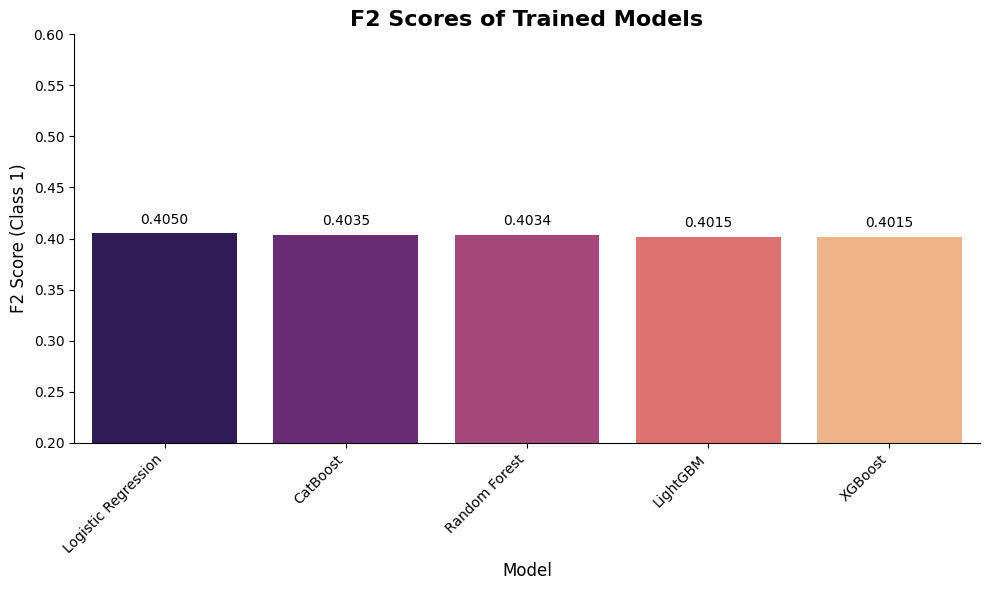

In [88]:
models = [
    "CatBoost",
    "LightGBM",
    "XGBoost",
    "Random Forest",
    "Logistic Regression",
]

f2_scores = [
    0.4035,
    0.4015,
    0.4015,
    0.4034,
    0.4050,
]
plot_model_f2_scores(models, f2_scores)

**Interpretation:***

- All models improved compared to a baseline of Dummy Classifier.

- Overall, very similar results.

## Cross-Validation

I will use cross-validation tests to see how well models generalizes to unseen data.



Cross-validating LR:

In [89]:
cross_validate_logistic_regression(
    pipeline_function=pipeline_stroke_selected_features_ratio_2_to_1,
    X=X_train,
    y=y_train,
    class_weight="balanced",
    undersample=True,
    n_splits=5,
)


PIPELINE FUNCTION: pipeline_stroke_selected_features_ratio_2_to_1
CLASS WEIGHT: balanced
UNDERSAMPLING: True

Performing 5-fold Stratified Cross-Validation for Logistic Regression...
Cross-validation complete.

--- Logistic Regression Cross-Validation Results ---
Precision Class 1: Mean = 0.1232, Std = 0.0213
Recall Class 1: Mean = 0.7851, Std = 0.1379
F1 Class 1: Mean = 0.2129, Std = 0.0362
F2 Class 1: Mean = 0.3778, Std = 0.0633
F1 Macro: Mean = 0.5201, Std = 0.0243


**Interpretation**

- High recall and low precision, no surprises.

- Used 2:1 sample ratio pipeline and balanced weights for best results.

#### Random Forest CV

Cross-validating RF:

In [90]:
cross_validate_random_forest(
    pipeline_function=pipeline_stroke_selected_features_ratio_2_to_1,
    X=X,
    y=y,
    n_estimators=100,
    class_weight=None,
    undersample=True,
    n_splits=5,
    random_state=24,
)


PIPELINE FUNCTION: pipeline_stroke_selected_features_ratio_2_to_1
CLASS WEIGHT: None
UNDERSAMPLING: True
N_ESTIMATORS: 100

Performing 5-fold Stratified Cross-Validation for Random Forest...
Cross-validation complete.

--- Random Forest Cross-Validation Results ---
Precision Class 1: Mean = 0.1387, Std = 0.0139
Recall Class 1: Mean = 0.5784, Std = 0.0532
F1 Class 1: Mean = 0.2236, Std = 0.0214
F2 Class 1: Mean = 0.3536, Std = 0.0324
F1 Macro: Mean = 0.5556, Std = 0.0143


**Interpretation**

- Higher F1 Macro score, but lower recall than LR.

- Used 2:1 sample ratio pipeline and no weights for best results.

#### XGBoost Cross-Validation

Cross-validating XGBoost:

In [91]:
cross_validate_xgboost(
    pipeline_function=pipeline_stroke_selected_features_ratio_2_to_1,
    X=X,
    y=y,
    n_estimators=1000,
    weight=2,
    undersample=True,
    n_splits=5,
    random_state=42,
)


PIPELINE FUNCTION: pipeline_stroke_selected_features_ratio_2_to_1
SCALE_POS_WEIGHT: 2.0000
UNDERSAMPLING: True
N_ESTIMATORS: 1000

Performing 5-fold Stratified Cross-Validation for XGBoost...
Cross-validation complete.

--- XGBoost Cross-Validation Results ---
Precision Class 1: Mean = 0.1087, Std = 0.0135
Recall Class 1: Mean = 0.6750, Std = 0.0862
F1 Class 1: Mean = 0.1872, Std = 0.0233
F2 Class 1: Mean = 0.3305, Std = 0.0412
F1 Macro: Mean = 0.5070, Std = 0.0143


**Interpretation**

- Worst results so far, but difference is small.

- Used 2:1 sample ratio pipeline and weight=2 for best results.

#### LightGBM CV

Cross-validating LightGBM:

In [92]:
cross_validate_lightgbm(
    pipeline_function=pipeline_stroke_selected_features_ratio_2_to_1,
    X=X,
    y=y,
    n_estimators=1000,
    weight=2,
    undersample=True,
    n_splits=5,
    random_state=42,
)


PIPELINE FUNCTION: pipeline_stroke_selected_features_ratio_2_to_1
SCALE_POS_WEIGHT: 2.0000
UNDERSAMPLING: True
N_ESTIMATORS: 1000

Performing 5-fold Stratified Cross-Validation for LightGBM...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Cross-validation complete.

--- LightGBM Cross-Validation Results ---
Precision Class 1: Mean = 0.1080, Std = 0.0100
Recall Class 1: Mean = 0.6749, Std = 0.0588
F1 Class 1: Mean = 0.1861, Std = 0.0170
F2 Class 1: Mean = 0.3291, Std = 0.0294
F1 Macro: Mean = 0.5056, Std = 0.0116


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


**Interpretation**

- Quite similar results to XGBoost.

- Used 2:1 sample ratio pipeline and weight=2 for best results.

#### CatBoost CV

Cross-validating CatBoost:

In [93]:
cross_validate_catboost(
    pipeline_function=pipeline_stroke_selected_features,
    X=X,
    y=y,
    iterations=1000,
    weight=1,
    undersample=True,
    n_splits=5,
    random_state=42,
)


PIPELINE FUNCTION: pipeline_stroke_selected_features
SCALE_POS_WEIGHT: 1.0000
UNDERSAMPLING: True
ITERATIONS: 1000

Performing 5-fold Stratified Cross-Validation for CatBoost...
Cross-validation complete.

--- CatBoost Cross-Validation Results ---
Precision Class 1: Mean = 0.1110, Std = 0.0104
Recall Class 1: Mean = 0.7350, Std = 0.0553
F1 Class 1: Mean = 0.1927, Std = 0.0171
F2 Class 1: Mean = 0.3456, Std = 0.0281
F1 Macro: Mean = 0.5037, Std = 0.0155


**Interpretation**

- Slightly better metrics than XGBoost and LightGBM.

- CatBoost achieved best result uniquely with 1:1 sample ratio pipeline, no weights were used.

#### Comparing All Models CV Results (F1 Macro and F2)

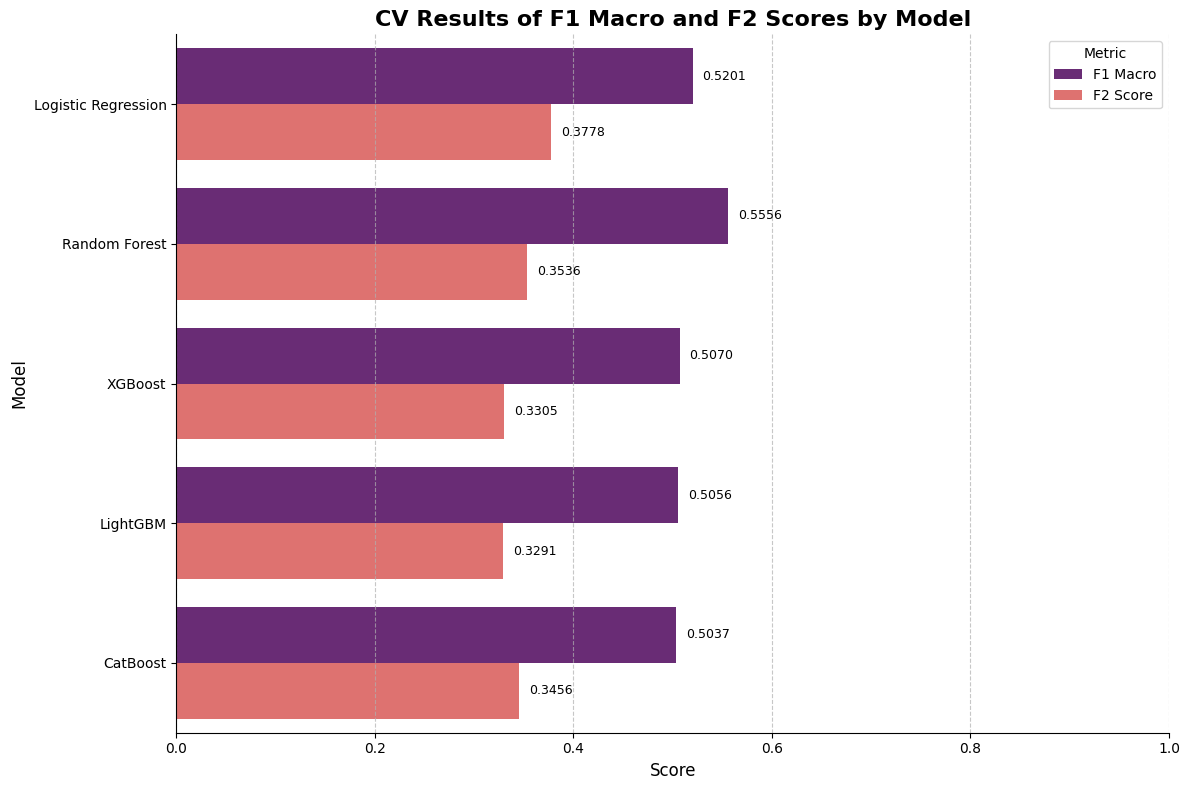

In [94]:
plot_model_f1_macro_f2_comparison(
    models=[
        "Logistic Regression",
        "Random Forest",
        "XGBoost",
        "LightGBM",
        "CatBoost",
    ],
    f1_macro_scores=[
        0.5201,
        0.5556,
        0.5070,
        0.5056,
        0.5037,
    ],
    f2_scores=[
        0.3778,
        0.3536,
        0.3305,
        0.3291,
        0.3456,
    ],
    xlim=(0.0, 1.0),
)

**Interpretation:** 

- Overall, very similar results.

- Best F1 Macro: Random Forest (0.5556) – strongest overall balance.

- Best F2 Score: Logistic Regression (0.3778) – better recall emphasis.

- CatBoost is competitive, with solid balance between both scores.

- LightGBM and XGBoost performed a little worse, so I will be move to Hyperparameter Tuning without them.

## Hyperparameter Tuning

### Hyperparameter Tuning: LR

I will use  RandomizedSearchCV, because it’s faster and more efficient than GridSearchCV.

**LR Tuning Notes:**
- C: Inverse of regularization strength. Lower = stronger regularization (simpler model). Typical range: 0.001–100.
- penalty: Type of regularization. 'l2' is ridge-like, helps control weights.
- solver: Algorithm to fit the model. 'lbfgs' and 'liblinear' handle small datasets well.
- class_weight: Adjusts balance between classes. 'balanced' helps with imbalanced data by weighting classes inversely to their frequencies.

First LR Tuning:

In [95]:
param_distributions = {
    "classifier__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "classifier__penalty": ["l2"],
    "classifier__solver": ["lbfgs", "liblinear"],
    "classifier__class_weight": [None, "balanced"],
}

bootstrap_diff_medianest_lr_model = tune_logistic_regression_rs(
    X=X_train,
    y=y_train,
    pipeline_function=pipeline_stroke_selected_features,
    param_distributions=param_distributions,
    undersample=True,
    n_iter=30,
    cv_folds=5,
    random_state=42,
)


PIPELINE FUNCTION: pipeline_stroke_selected_features
UNDERSAMPLING: True

Performing RandomizedSearchCV with 30 iterations...

RandomizedSearchCV complete.

Best Parameters Found:
{'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__class_weight': None, 'classifier__C': 0.01}

--- Best Cross-Validation Scores ---
F1 Macro Score: 0.5423
F1 Class 1 Score: 0.2314
F2 Class 1 Score: 0.3967
Recall (Class 1): 0.7589
Precision (Class 1): 0.1366


**Interpretation:** Modest scores, but let's try to improve it.

2 LR Tuning:

- I will zoom in around 0.01 (best last time), finer steps.

- Add saga solver for extra flexibility.

In [96]:
param_distributions = {
    "classifier__C": [0.001, 0.003, 0.01, 0.03, 0.1, 0.3],
    "classifier__penalty": ["l2"],
    "classifier__solver": ["lbfgs", "liblinear", "saga"],
    "classifier__class_weight": [None, "balanced"],
}


bootstrap_diff_medianest_lr_model = tune_logistic_regression_rs(
    X=X_train,
    y=y_train,
    pipeline_function=pipeline_stroke_selected_features,
    param_distributions=param_distributions,
    undersample=True,
    n_iter=30,
    cv_folds=5,
    random_state=42,
)


PIPELINE FUNCTION: pipeline_stroke_selected_features
UNDERSAMPLING: True

Performing RandomizedSearchCV with 30 iterations...

RandomizedSearchCV complete.

Best Parameters Found:
{'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__class_weight': 'balanced', 'classifier__C': 0.03}

--- Best Cross-Validation Scores ---
F1 Macro Score: 0.5448
F1 Class 1 Score: 0.2361
F2 Class 1 Score: 0.4056
Recall (Class 1): 0.7789
Precision (Class 1): 0.1392


**Interpretation:** It improved slightly across all key metrics, let's try one more time.

Third LR Tuning - zooming in tightly around 0.03 (last best):

In [97]:
param_distributions = {
    "classifier__C": [0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05],
    "classifier__penalty": ["l2"],
    "classifier__solver": ["lbfgs", "liblinear", "saga"],
    "classifier__class_weight": [None, "balanced"],
}

bootstrap_diff_medianest_lr_model = tune_logistic_regression_rs(
    X=X_train,
    y=y_train,
    pipeline_function=pipeline_stroke_selected_features,
    param_distributions=param_distributions,
    undersample=True,
    n_iter=30,
    cv_folds=5,
    random_state=42,
)


PIPELINE FUNCTION: pipeline_stroke_selected_features
UNDERSAMPLING: True

Performing RandomizedSearchCV with 30 iterations...

RandomizedSearchCV complete.

Best Parameters Found:
{'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__class_weight': None, 'classifier__C': 0.035}

--- Best Cross-Validation Scores ---
F1 Macro Score: 0.5458
F1 Class 1 Score: 0.2372
F2 Class 1 Score: 0.4069
Recall (Class 1): 0.7789
Precision (Class 1): 0.1400


Again, very small improvement.

**Final Logistic Regression Tuning Results:**

- Best F1 Macro Score: 0.5458

- F1 Class 1: 0.2372

- F2 Class 1: 0.4069

- Recall (Class 1): 0.7789

- Precision (Class 1): 0.1400

**Best Hyperparameters:**

- solver: lbfgs

- penalty: l2

- class_weight: None

- C: 0.035

Saving best LR model:

In [98]:
joblib.dump(bootstrap_diff_medianest_lr_model, "best_lr_pipeline.pkl")

['best_lr_pipeline.pkl']

### Hyperparameter Tuning: RF

First RF tuning:

In [99]:
param_distributions_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [4, 5, 6, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "class_weight": [None, "balanced", "balanced_subsample"],
}

best_rf_model = tune_model_optuna_with_grid_rf(
    X=X_train,
    y=y_train,
    pipeline_function=pipeline_stroke,
    model_class=RandomForestClassifier,
    param_distributions=param_distributions_rf,
    n_trials=30,
    cv_folds=5,
    undersample=True,
    random_state=42,
)

[I 2025-07-20 16:38:05,057] A new study created in memory with name: no-name-4a9f2f43-2b6c-49fb-8ad7-a99ee1db46a6


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-07-20 16:38:05,292] Trial 0 finished with value: 0.4863243313927216 and parameters: {'n_estimators': 175, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 3, 'class_weight': None}. Best is trial 0 with value: 0.4863243313927216.
[I 2025-07-20 16:38:05,660] Trial 1 finished with value: 0.488220301707204 and parameters: {'n_estimators': 274, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 1, 'class_weight': None}. Best is trial 0 with value: 0.4863243313927216.
[I 2025-07-20 16:38:05,899] Trial 2 finished with value: 0.48092292167933015 and parameters: {'n_estimators': 136, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 3, 'class_weight': 'balanced_subsample'}. Best is trial 2 with value: 0.48092292167933015.
[I 2025-07-20 16:38:06,075] Trial 3 finished with value: 0.4851112650534325 and parameters: {'n_estimators': 128, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 2, 'class_weight': None}. Best is trial 2 with value: 0.48092292

RF second tuning attempt (added lower max depth possible, adjusted other parametres a bit):

In [100]:
param_distributions_rf_next = {
    "n_estimators": [200, 225, 250, 275, 300],
    "max_depth": [1, 2, 3, 4, 5, 6, 8],
    "min_samples_split": [2, 3, 4, 5, 6],
    "min_samples_leaf": [1, 2, 3],
    "class_weight": [None, "balanced", "balanced_subsample"],
}


best_rf_model = tune_model_optuna_with_grid_rf(
    X=X_train,
    y=y_train,
    pipeline_function=pipeline_stroke,
    model_class=RandomForestClassifier,
    param_distributions=param_distributions_rf,
    n_trials=30,
    cv_folds=5,
    undersample=True,
    random_state=42,
)

[I 2025-07-20 16:38:15,858] A new study created in memory with name: no-name-a0c6bab9-5aa8-431a-9791-ef12181aa272


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-07-20 16:38:16,169] Trial 0 finished with value: 0.4863243313927216 and parameters: {'n_estimators': 175, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 3, 'class_weight': None}. Best is trial 0 with value: 0.4863243313927216.
[I 2025-07-20 16:38:16,589] Trial 1 finished with value: 0.488220301707204 and parameters: {'n_estimators': 274, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 1, 'class_weight': None}. Best is trial 0 with value: 0.4863243313927216.
[I 2025-07-20 16:38:16,865] Trial 2 finished with value: 0.48092292167933015 and parameters: {'n_estimators': 136, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 3, 'class_weight': 'balanced_subsample'}. Best is trial 2 with value: 0.48092292167933015.
[I 2025-07-20 16:38:17,053] Trial 3 finished with value: 0.4851112650534325 and parameters: {'n_estimators': 128, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 2, 'class_weight': None}. Best is trial 2 with value: 0.48092292

**Interpretation:** It had no effect.

**Final RF Tuning Results:**

- Best F1 Macro Score: 0.5241

- F1 Class 1: 0.2183

- F2 Class 1: 0.3870

- Recall (Class 1): 0.7991

- Precision (Class 1): 0.1264

**Best Hyperparameters:**

- n_estimators: 235

- max_depth: 4

- min_samples_split: 3

- min_samples_leaf: 1

- class_weight: balanced



Saving best RF model:

In [101]:
joblib.dump(best_rf_model, "best_rf_pipeline.pkl")

['best_rf_pipeline.pkl']

### CatBoost Hyperparameter Tuning

First Catboost tuning:

In [102]:
param_distributions_catboost = {
    "iterations": [100, 200, 300],
    "depth": [4, 5, 6, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "l2_leaf_reg": [1, 3, 5, 7, 9],
    "bootstrap_type": ["Bayesian", "Bernoulli", "MVS"],
    "subsample": [0.1, 0.5, 0.9],
}

best_catboost_model = tune_model_optuna_with_grid_cb(
    X=X_train,
    y=y_train,
    pipeline_function=pipeline_stroke_selected_features,
    param_distributions=param_distributions_catboost,
    n_trials=30,
    cv_folds=5,
    undersample=True,
    random_state=42,
)

[I 2025-07-20 16:38:24,200] A new study created in memory with name: no-name-00a1cd60-51b7-4304-8bd1-fbc900cb3d59


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-07-20 16:38:24,448] Trial 0 finished with value: 0.47708895852145383 and parameters: {'bootstrap_type': 'Bernoulli', 'subsample': 0.5789267873576293, 'iterations': 131, 'depth': 5, 'learning_rate': 0.015227525095137952, 'l2_leaf_reg': 8}. Best is trial 0 with value: 0.47708895852145383.
[I 2025-07-20 16:38:24,680] Trial 1 finished with value: 0.5052122879742501 and parameters: {'bootstrap_type': 'Bernoulli', 'subsample': 0.8759278817295955, 'iterations': 267, 'depth': 5, 'learning_rate': 0.02636424704863906, 'l2_leaf_reg': 2}. Best is trial 0 with value: 0.47708895852145383.
[I 2025-07-20 16:38:24,803] Trial 2 finished with value: 0.4895072389341659 and parameters: {'bootstrap_type': 'Bernoulli', 'subsample': 0.3329833121584336, 'iterations': 222, 'depth': 4, 'learning_rate': 0.03629301836816964, 'l2_leaf_reg': 4}. Best is trial 0 with value: 0.47708895852145383.
[I 2025-07-20 16:38:24,915] Trial 3 finished with value: 0.5023976190332775 and parameters: {'bootstrap_type': 'Bern

Second CatBoost tuning attempt:

- Lowered depth options.

- Made even slower learning available.

- Added more subsample options

In [103]:
param_distributions_catboost = {
    "iterations": [100, 200, 300],
    "depth": [3, 4, 5, 6],
    "learning_rate": [0.001, 0.01, 0.05, 0.1],
    "l2_leaf_reg": [3, 5, 7, 9, 10],
    "bootstrap_type": ["Bayesian", "Bernoulli", "MVS"],
    "subsample": [0.1, 0.5, 0.9, 1.0],
}

best_catboost_model = tune_model_optuna_with_grid_cb(
    X=X_train,
    y=y_train,
    pipeline_function=pipeline_stroke_selected_features,
    param_distributions=param_distributions_catboost,
    n_trials=30,
    cv_folds=5,
    undersample=True,
    random_state=42,
)

[I 2025-07-20 16:38:29,854] A new study created in memory with name: no-name-f4a44b5f-6c0b-4d4c-b2df-ad06deef1a1e


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-07-20 16:38:30,041] Trial 0 finished with value: 0.4449131690370247 and parameters: {'bootstrap_type': 'Bernoulli', 'subsample': 0.6387926357773329, 'iterations': 131, 'depth': 3, 'learning_rate': 0.006750277604651747, 'l2_leaf_reg': 9}. Best is trial 0 with value: 0.4449131690370247.
[I 2025-07-20 16:38:30,176] Trial 1 finished with value: 0.4823409633858242 and parameters: {'bootstrap_type': 'Bernoulli', 'subsample': 0.9729188669457949, 'iterations': 267, 'depth': 3, 'learning_rate': 0.01900067175350296, 'l2_leaf_reg': 4}. Best is trial 0 with value: 0.4449131690370247.
[I 2025-07-20 16:38:30,298] Trial 2 finished with value: 0.48845666682942723 and parameters: {'bootstrap_type': 'Bernoulli', 'subsample': 0.36210622617823773, 'iterations': 222, 'depth': 3, 'learning_rate': 0.0299223202049866, 'l2_leaf_reg': 5}. Best is trial 0 with value: 0.4449131690370247.
[I 2025-07-20 16:38:30,412] Trial 3 finished with value: 0.4981472456450733 and parameters: {'bootstrap_type': 'Bernoul

**Interpretation:** I got higher F1 macro and lower recall, but higher precision. Higher F2 overall.

Third Catboost tuning attempt:

- Made even slower learning rate possible

- Lowered depth options to 1.

In [104]:
param_distributions_catboost = {
    "iterations": [200, 300, 400],
    "depth": [1, 2, 3, 4, 5],
    "learning_rate": [0.0001, 0.001, 0.01, 0.05, 0.1],
    "l2_leaf_reg": [7, 9, 10, 11, 12],
    "bootstrap_type": ["Bayesian", "Bernoulli", "MVS"],
    "subsample": [0.1, 0.5, 0.9, 1.0],
}

best_catboost_model = tune_model_optuna_with_grid_cb(
    X=X_train,
    y=y_train,
    pipeline_function=pipeline_stroke_selected_features,
    param_distributions=param_distributions_catboost,
    n_trials=30,
    cv_folds=5,
    undersample=True,
    random_state=42,
)

[I 2025-07-20 16:38:33,601] A new study created in memory with name: no-name-65693c34-f582-4dc0-ac66-799ec2d30139


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-07-20 16:38:33,730] Trial 0 finished with value: 0.43097095976864674 and parameters: {'bootstrap_type': 'Bernoulli', 'subsample': 0.6387926357773329, 'iterations': 231, 'depth': 1, 'learning_rate': 0.005902552855603127, 'l2_leaf_reg': 12}. Best is trial 0 with value: 0.43097095976864674.
[I 2025-07-20 16:38:33,867] Trial 1 finished with value: 0.4778428851188231 and parameters: {'bootstrap_type': 'Bernoulli', 'subsample': 0.9729188669457949, 'iterations': 367, 'depth': 2, 'learning_rate': 0.01826431422398935, 'l2_leaf_reg': 8}. Best is trial 0 with value: 0.43097095976864674.
[I 2025-07-20 16:38:33,963] Trial 2 finished with value: 0.4601869239300036 and parameters: {'bootstrap_type': 'Bernoulli', 'subsample': 0.36210622617823773, 'iterations': 322, 'depth': 1, 'learning_rate': 0.029285250388668294, 'l2_leaf_reg': 9}. Best is trial 0 with value: 0.43097095976864674.
[I 2025-07-20 16:38:34,060] Trial 3 finished with value: 0.4759457358990973 and parameters: {'bootstrap_type': 'B

**Interpretation:** Improved F2 by little: higher precision, yet at recall cost.

**Final CatBoost Tuning Results**:

- Best F1 Macro Score: 0.5728

- F1 Class 1: 0.2530

- F2 Class 1: 0.3975

- Recall (Class 1): 0.6439

- Precision (Class 1): 0.1576

**Best hyperparameters:**

- bootstrap_type: MVS

- Iterations: 217

- depth: 1

- learning_rate: 0.0046182061621627525

- 2_leaf_reg: 8


Saving best CB Model:

In [105]:
joblib.dump(best_catboost_model, "best_catboost_pipeline.pkl")

['best_catboost_pipeline.pkl']

### Comparing Tuned Models

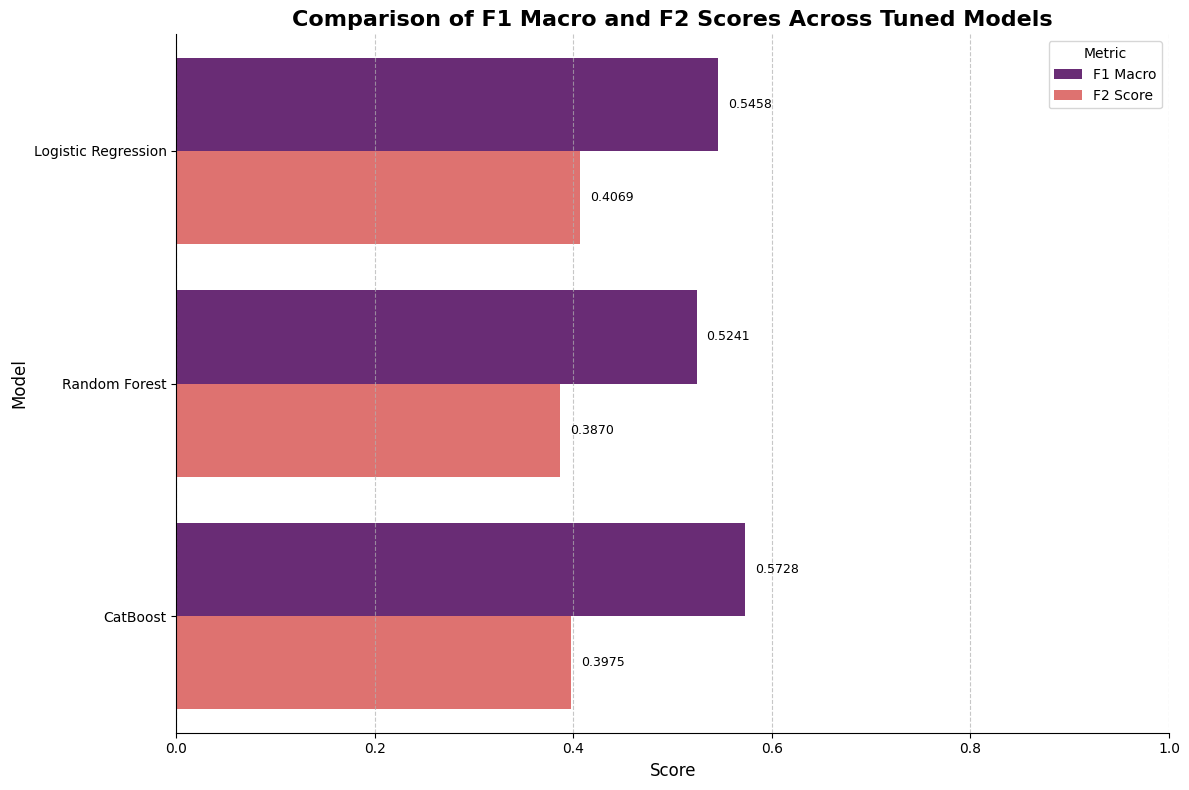

In [106]:
plot_model_f1_macro_f2_comparison(
    models=[
        "Logistic Regression",
        "Random Forest",
        "CatBoost",
    ],
    f1_macro_scores=[
        0.5458,
        0.5241,
        0.5728,
    ],
    f2_scores=[
        0.4069,
        0.3870,
        0.3975,
    ],
    xlim=(0.0, 1.0),
    title="Comparison of F1 Macro and F2 Scores Across Tuned Models",
)

**Interpretation:** 

- All three models perform reasonably well.

- Logistic Regression has solid F2 (Quite high recall, but lower precision). 

- For RF tuning, I used pipeline with all features, so it's lower performance proves that selected features pipeline were generally more effective.

- CatBoost – Best overall balance of F1 Macro (0.5728) and second best F2 (0.3975).



## Ensemble Model

### Building Voting Ensemble Model

I will buid Ensemble model using Voting Classifier.

In [107]:
ensemble_model = VotingClassifier(
    estimators=[
        ("lr", bootstrap_diff_medianest_lr_model),
        ("rf", best_rf_model),
        ("catboost", best_catboost_model),
    ],
    voting="soft",
    n_jobs=-1,
)

Fitting Ensemble Model on training data:

In [108]:
ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('feature_engineering',
                                               CombinedFeatureTransformer()),
                                              ('final_preprocessing',
                                               ColumnTransformer(transformers=[('cat_encoder',
                                                                                OneHotEncoder(categories=[['Under '
                                                                                                           '18',
                                                                                                           'Young '
                                                                                                           'Adult',
                                                                                                           'Middle-Aged '
                                                                                                           'Adult',
                                                                                                           'Senior '
                                                                                                           'Adult',
                                                                                                           'Elderly'],
                                                                                                          ['never '
                                                                                                           'smoked',
                                                                                                           'formerly '
                                                                                                           'smoked',
                                                                                                           'smokes',
                                                                                                           'unknown'],
                                                                                                          ['Underweight',
                                                                                                           'No...
                                                                                                           'Prediabetes',
                                                                                                           'Diabetes'],
                                                                                                          ['Private',
                                                                                                           'Self-employed',
                                                                                                           'Govt_job',
                                                                                                           'children',
                                                                                                           'Never_worked']],
                                                                                              handle_unknown='ignore'),
                                                                                ['age_group',
                                                                                 'smoking_status',
                                                                                 'bmi_category',
                                                                                 'glucose_category_log',
                                                                                 'work_type'])])),
                                              ('undersampler',
                                               RandomUnderSampler(random_state=42)),
                                              ('cl

Cross-Validating Ensemble Model:

In [109]:
evaluate_model_cv(ensemble_model, X_train, y_train, cv=5)


Evaluating model: VotingClassifier
Cross-validation folds: 5

f1_macro: 0.5278
f1_class_1: 0.2163
f2_class_1: 0.3783
recall_class_1: 0.7579
precision_class_1: 0.1263


{'fit_time': array([0.25422096, 0.26797414, 0.24695086, 0.24524403, 0.25660229]),
 'score_time': array([0.05954719, 0.06079602, 0.04670501, 0.06152487, 0.04365897]),
 'test_f1_macro': array([0.51363911, 0.53099669, 0.53905387, 0.51825508, 0.53692479]),
 'test_f1_class_1': array([0.19230769, 0.20430108, 0.23300971, 0.21333333, 0.23853211]),
 'test_f2_class_1': array([0.33898305, 0.3442029 , 0.40540541, 0.38095238, 0.42207792]),
 'test_recall_class_1': array([0.68965517, 0.63333333, 0.8       , 0.8       , 0.86666667]),
 'test_precision_class_1': array([0.11173184, 0.12179487, 0.13636364, 0.12307692, 0.13829787])}

Adjusting weights:

In [110]:
ensemble_model = VotingClassifier(
    estimators=[
        ("lr", bootstrap_diff_medianest_lr_model),
        ("rf", best_rf_model),
        ("catboost", best_catboost_model),
    ],
    voting="soft",
    weights=[1, 1, 3],
)

In [111]:
evaluate_model_cv(ensemble_model, X_train, y_train, cv=5)


Evaluating model: VotingClassifier
Cross-validation folds: 5

f1_macro: 0.5550
f1_class_1: 0.2375
f2_class_1: 0.3927
recall_class_1: 0.6975
precision_class_1: 0.1432


{'fit_time': array([0.37381983, 0.34797502, 0.34607005, 0.33789492, 0.34205008]),
 'score_time': array([0.04615927, 0.06127501, 0.06461287, 0.0639019 , 0.06208777]),
 'test_f1_macro': array([0.52359066, 0.55901327, 0.54926471, 0.56392762, 0.5793741 ]),
 'test_f1_class_1': array([0.19251337, 0.2345679 , 0.22352941, 0.25945946, 0.27745665]),
 'test_f2_class_1': array([0.32846715, 0.37698413, 0.36538462, 0.43636364, 0.45627376]),
 'test_recall_class_1': array([0.62068966, 0.63333333, 0.63333333, 0.8       , 0.8       ]),
 'test_precision_class_1': array([0.11392405, 0.14393939, 0.13571429, 0.15483871, 0.16783217])}

**Interpretation:** Changing weights to put more emphasis on CatBoost increased almost all metrics (Except Recall).

In [112]:
ensemble_model = VotingClassifier(
    estimators=[
        ("lr", bootstrap_diff_medianest_lr_model),
        ("rf", best_rf_model),
        ("catboost", best_catboost_model),
    ],
    voting="soft",
    weights=[2, 0, 4],
)

In [113]:
evaluate_model_cv(ensemble_model, X_train, y_train, cv=5)


Evaluating model: VotingClassifier
Cross-validation folds: 5

f1_macro: 0.5678
f1_class_1: 0.2509
f2_class_1: 0.4042
recall_class_1: 0.6839
precision_class_1: 0.1537


{'fit_time': array([0.27652192, 0.28366899, 0.27352095, 0.26951814, 0.26800513]),
 'score_time': array([0.06115127, 0.06101823, 0.05980015, 0.0580759 , 0.05734777]),
 'test_f1_macro': array([0.53006388, 0.56279582, 0.56057348, 0.58071135, 0.6048854 ]),
 'test_f1_class_1': array([0.19428571, 0.23899371, 0.23225806, 0.27906977, 0.30967742]),
 'test_f2_class_1': array([0.32442748, 0.3815261 , 0.36734694, 0.45801527, 0.48979592]),
 'test_recall_class_1': array([0.5862069 , 0.63333333, 0.6       , 0.8       , 0.8       ]),
 'test_precision_class_1': array([0.11643836, 0.14728682, 0.144     , 0.16901408, 0.192     ])}

**Interpretation:** Putting even more weights on CatBoost(4), giving no weights to RF (0) and giving inbetween emphasis on LR (2), gave me best result.

### Comparing Ensemble Model vs CatBoost

Let's compare two best models to decide which model is best.

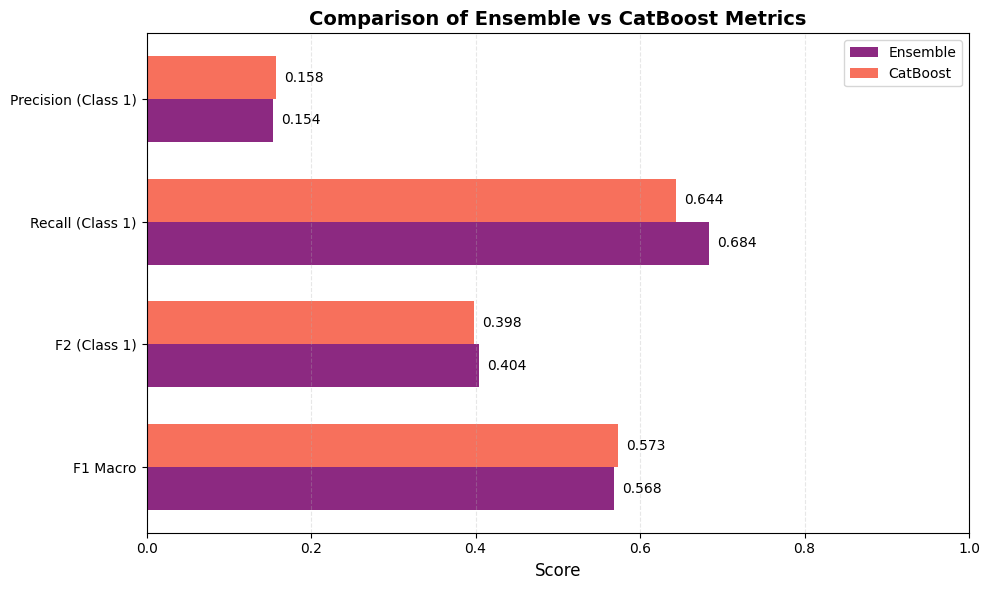

In [114]:
compare_two_models_scores(
    model_names=["Ensemble", "CatBoost"],
    f1_macro_scores=[0.5678, 0.5728],
    f2_scores=[0.4042, 0.3975],
    recall_scores=[0.6839, 0.6439],
    precision_scores=[0.1537, 0.1576],
    title="Comparison of Ensemble vs CatBoost Metrics",
)

**Interpretation:**

- Both models are close in performance.

- CatBoost has slightly better overall F1 Macro and Precision.

- Ensemble achieves higher F2 and Recall, indicating it may better capture positives but with more false positives.

- Since in this project Recall has higher priority, I will choose Ensemble model as best model.

## Treshold Tuning on Validation Set (Ensemble Model)

### Treshold Tuning Ensemble Model

Training ensemble model on the training data:

In [115]:
ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('feature_engineering',
                                               CombinedFeatureTransformer()),
                                              ('final_preprocessing',
                                               ColumnTransformer(transformers=[('cat_encoder',
                                                                                OneHotEncoder(categories=[['Under '
                                                                                                           '18',
                                                                                                           'Young '
                                                                                                           'Adult',
                                                                                                           'Middle-Aged '
                                                                                                           'Adult',
                                                                                                           'Senior '
                                                                                                           'Adult',
                                                                                                           'Elderly'],
                                                                                                          ['never '
                                                                                                           'smoked',
                                                                                                           'formerly '
                                                                                                           'smoked',
                                                                                                           'smokes',
                                                                                                           'unknown'],
                                                                                                          ['Underweight',
                                                                                                           'No...
                                                                                                           'Prediabetes',
                                                                                                           'Diabetes'],
                                                                                                          ['Private',
                                                                                                           'Self-employed',
                                                                                                           'Govt_job',
                                                                                                           'children',
                                                                                                           'Never_worked']],
                                                                                              handle_unknown='ignore'),
                                                                                ['age_group',
                                                                                 'smoking_status',
                                                                                 'bmi_category',
                                                                                 'glucose_category_log',
                                                                                 'work_type'])])),
                                              ('undersampler',
                                               RandomUnderSampler(random_state=42)),
                                              ('cl

Getting predicted probabilities on the validation set:

In [116]:
probs_ensemble = ensemble_model.predict_proba(X_val)[:, 1]

Generatic treshold scores by other metrics:

In [117]:
thresholds = np.arange(0.1, 0.9, 0.05)

print("Threshold | F1 Macro | F2 Score | Recall | Precision")
print("-----------------------------------------------------")

for t in thresholds:
    preds = (probs_ensemble >= t).astype(int)
    f1_macro = f1_score(y_val, preds, average="macro", zero_division=0)
    f2 = fbeta_score(y_val, preds, beta=2, zero_division=0)
    recall = recall_score(y_val, preds, zero_division=0)
    precision = precision_score(y_val, preds, zero_division=0)
    print(f"  {t:.2f}    |  {f1_macro:.4f} | {f2:.4f} | {recall:.4f} | {precision:.4f}")

Threshold | F1 Macro | F2 Score | Recall | Precision
-----------------------------------------------------
  0.10    |  0.0466 | 0.2046 | 1.0000 | 0.0489
  0.15    |  0.0466 | 0.2046 | 1.0000 | 0.0489
  0.20    |  0.0466 | 0.2046 | 1.0000 | 0.0489
  0.25    |  0.0466 | 0.2046 | 1.0000 | 0.0489
  0.30    |  0.1702 | 0.2287 | 1.0000 | 0.0560
  0.35    |  0.3299 | 0.2800 | 0.9800 | 0.0726
  0.40    |  0.3829 | 0.3097 | 0.9800 | 0.0829
  0.45    |  0.4990 | 0.3654 | 0.8200 | 0.1136
  0.50    |  0.5774 | 0.4084 | 0.6600 | 0.1618
  0.55    |  0.5820 | 0.4071 | 0.6400 | 0.1658
  0.60    |  0.5871 | 0.3989 | 0.6000 | 0.1705
  0.65    |  0.5628 | 0.1626 | 0.1600 | 0.1739
  0.70    |  0.4875 | 0.0000 | 0.0000 | 0.0000
  0.75    |  0.4875 | 0.0000 | 0.0000 | 0.0000
  0.80    |  0.4875 | 0.0000 | 0.0000 | 0.0000
  0.85    |  0.4875 | 0.0000 | 0.0000 | 0.0000


Generating treshold graph:

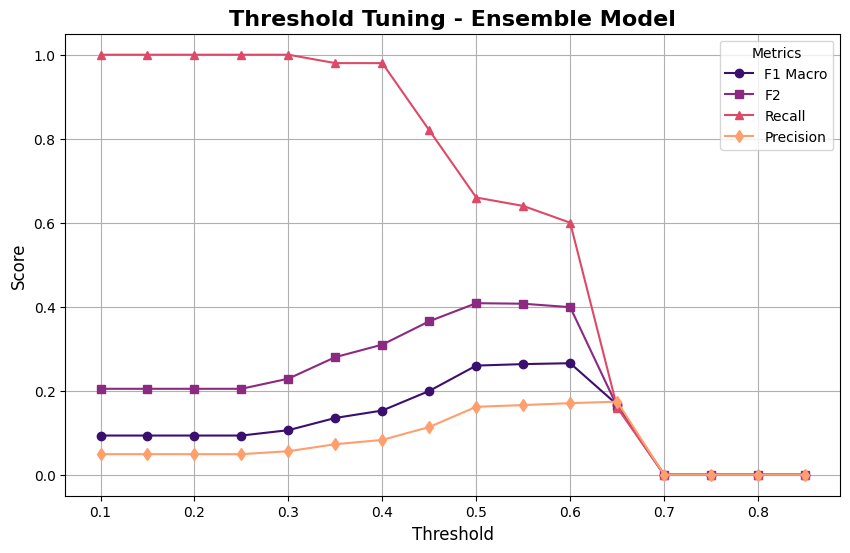

In [118]:
plot_threshold_tuning(probs_ensemble, y_val, title="Threshold Tuning - Ensemble Model")

**Interpretation:** 

- As the threshold increases, recall steadily drops while precision rises slightly. F1 and F2 scores peak around 0.5–0.6, indicating the best balance between catching positives and avoiding false alarms is in this range. 

- I will go with 0.5 treshold as it posseses highest Recall from other best options.

## Model Evaluation

Giving the model’s confidence scores for each test example being class 1:

In [119]:
probs = ensemble_model.predict_proba(X_test)[:, 1]

Describing best treshold discovered.

In [120]:
best_threshold = 0.5

Converting predicted probabilities into final class predictions, using chosen threshold :



In [121]:
final_preds = (probs >= best_threshold).astype(int)

Predicting probabilities on test set:

In [122]:
y_proba = ensemble_model.predict_proba(X_test)[:, 1]

Generating confusion matrix of Ensemble model:


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.98      0.79      0.88       972
           1       0.14      0.66      0.23        50

    accuracy                           0.79      1022
   macro avg       0.56      0.73      0.55      1022
weighted avg       0.94      0.79      0.84      1022


--- Confusion Matrix ---
[[770 202]
 [ 17  33]]

--- F2 Score (Class 1) ---
F2 Score (β=2): 0.3793


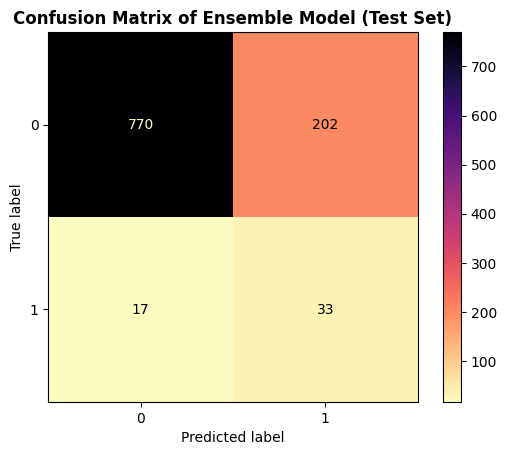

In [123]:
print("\n--- Classification Report ---")
print(classification_report(y_test, final_preds))

print("\n--- Confusion Matrix ---")
print(confusion_matrix(y_test, final_preds))

f2 = fbeta_score(y_test, final_preds, beta=2, pos_label=1, zero_division=0)
print(f"\n--- F2 Score (Class 1) ---")
print(f"F2 Score (β=2): {f2:.4f}")

cm = confusion_matrix(y_test, final_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="magma_r")
plt.title("Confusion Matrix of Ensemble Model (Test Set)", weight="bold")
plt.show()

- The ensemble model achieves strong overall accuracy and class 0 precision, but struggles with class 1 precision. 

- Recall for class 1 is reasonable (66%), while  precision  low (14%), indicating many false positives. 

- 17 real positive cases were incorrectly labeled as negative by the model, indicating the model flaws. 

- The 202 false positives show the model tends to over-predict positives, which could lead to unnecessary follow-up actions or costs.

#### ROC and PR AUC Curve

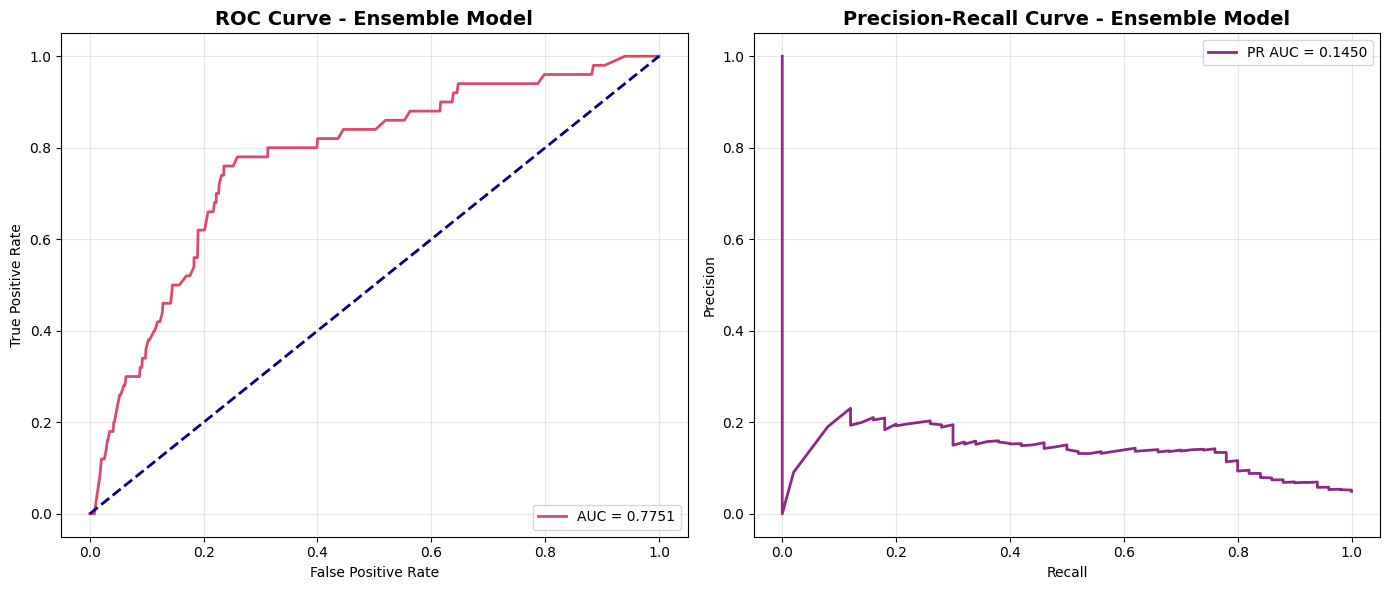

In [124]:
plot_roc_pr_curves(y_test, y_proba, model_name="Ensemble Model")

**Interpretation:**

- AUC = 0.7751 indicates good overall discrimination.

- Model distinguishes between classes better than chance (0.5) but not perfect.

- PR AUC = 0.1450 is low, reflecting class imbalance.

- Precision drops quickly as recall increases, showing many false positives when trying to capture all positives.

### Business Metric Translation

Ensemble model identifies high-risk cases reasonably well (macro F1 ~0.55, AUC ~0.77), but with some over- and under-predictions. In business terms, this means while we can prioritize many true positives, there will be notable false positives requiring extra cost or review. Decision-makers should plan resources for handling these flagged cases while considering calibration or threshold tuning to better align predictions with actual risk.

## Interprepability

Getting the CatBoost pipeline from the ensemble:



In [125]:
catboost_pipeline = ensemble_model.named_estimators_["catboost"]

Getting features names:

In [126]:
final_preprocessor = catboost_pipeline.named_steps["final_preprocessing"]
feature_names = final_preprocessor.get_feature_names_out()

Extracting the trained CatBoostClassifier:

In [127]:
catboost_model = catboost_pipeline.named_steps["classifier"]

Preprocessing test data:

In [128]:
X_test_engineered = catboost_pipeline.named_steps["feature_engineering"].transform(
    X_test
)
X_test_transformed = catboost_pipeline.named_steps["final_preprocessing"].transform(
    X_test_engineered
)

Creating SHAP Explainer:

In [129]:
explainer = shap.TreeExplainer(catboost_model)

Computing SHAP values:

In [130]:
shap_values = explainer.shap_values(X_test_transformed)

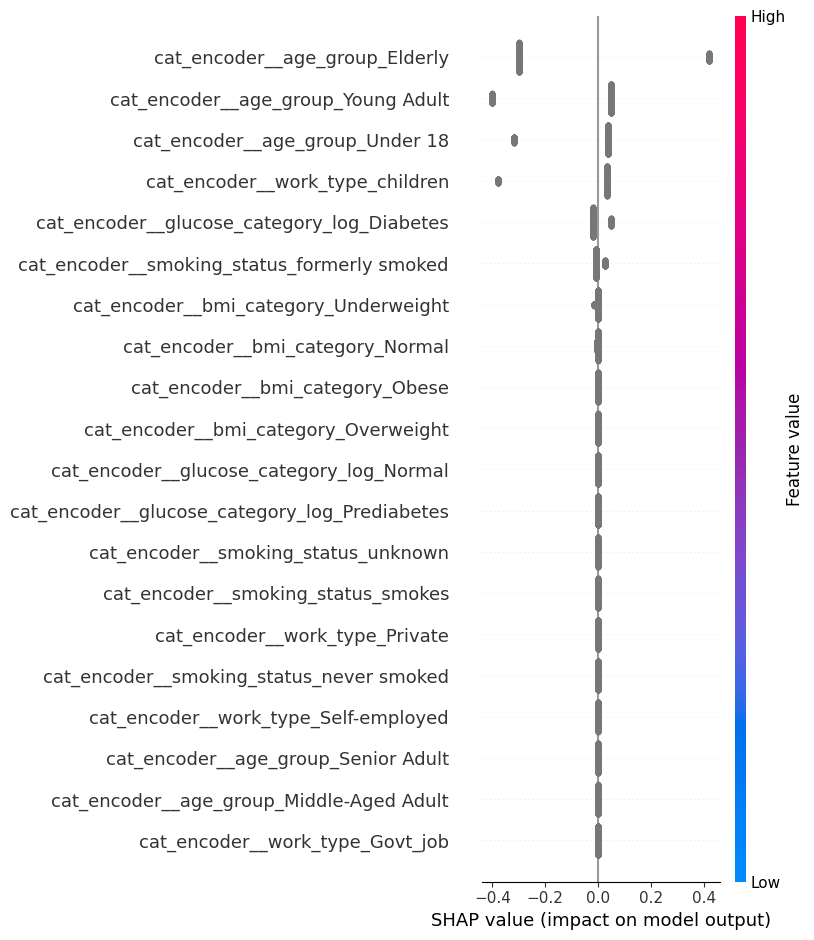

In [131]:
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

**Interpretation:**

- Features like age_group_Elderly, age_group_Young Adult, and work_type_children appear highest—indicating they have strongest impact on the model’s predictions.
- Categories for glucose_category_log and bmi_category also show influence—suggesting glucose levels and BMI categories matter in predicting stroke risk.
- Smoking-related features (smoking_status) and work_type categories have smaller, but still visible, contributions.
- Majority of the categories had no impact.

## Model Deployment

### Saving model


In [132]:
joblib.dump(ensemble_model, "stroke_risk_pipeline_ensemble_model.joblib")

print("Model saved.")

Model saved.


In [133]:
app = FastAPI(title="Stroke Risk Prediction API")

### Input and Output Schema

#### Input Schema

Format: JSON array of objects for batch requests, or a single JSON object for single prediction.

Example Input (JSON) :

In [134]:
{
    "age": 65,
    "hypertension": 1,
    "heart_disease": 0,
    "avg_glucose_level": 70,
    "bmi": 40,
    "gender": "Male",
    "ever_married": "Yes",
    "work_type": "Private",
    "residence_type": "Rural",
    "smoking_status": "never smoked",
}

{'age': 65,
 'hypertension': 1,
 'heart_disease': 0,
 'avg_glucose_level': 70,
 'bmi': 40,
 'gender': 'Male',
 'ever_married': 'Yes',
 'work_type': 'Private',
 'residence_type': 'Rural',
 'smoking_status': 'never smoked'}

### Output Schema

Model predicts probability of stroke or class label:

- If probability: Float between 0 and 1

- If class: 0 or 1

Example (classification): {
  "stroke_prediction": 0
}


Example (probability): {
  "stroke_probability": 0.15
}

### Notes for API Design

- Input should match the raw feature columns exactly—the pipeline handles feature engineering.

- Always validate input types (e.g. floats for age, categorical strings for gender).

- Return both class and probability if useful for the business context.

## Documentation

### Ethical considerations

- Bias & Fairness: The model uses health, demographic, and lifestyle features. There's risk of encoding existing healthcare inequalities (e.g. differences in care by gender or socioeconomic status). Care should be taken to monitor fairness metrics and avoid reinforcing discrimination.

- Privacy: The model relies on sensitive health data. Strict data privacy protocols (e.g. encryption, access control) are required to ensure compliance with health data regulations (e.g. HIPAA, GDPR).

- Transparency: Clinicians and stakeholders must understand how predictions are generated. Tools like SHAP values can help explain model decisions.

- Human Oversight: The model should not replace professional medical judgment. Predictions should be used as decision-support, not automatic diagnosis.

### Limitations

- Data Quality: The model is only as good as the data it was trained on. Missing or biased records could harm accuracy.

- Generalizability: The model may not perform equally well on different populations (e.g. other countries, healthcare systems) without retraining and validation.

- Threshold Tuning: Performance depends on choosing appropriate thresholds for classification, which may need adjustment for different clinical settings.

- Interpretability: Even with SHAP, complex models can be hard for non-technical users to fully understand.

### Maintenance Plan

- Monitoring: Track model performance over time with real-world data (e.g. F1 score, ROC-AUC, calibration). Alert if metrics drift.

- Data Drift Detection: Periodically check for changes in patient population distributions (e.g. age, glucose levels).

- Retraining: Schedule periodic retraining (e.g. annually) with new, high-quality data to maintain accuracy.

- Versioning: Maintain version control of models and data pipelines. Document changes.

- Compliance Review: Regularly review privacy and ethics policies to ensure continued compliance with regulations.

## Conclusion

According to the this specific dataset the most typical people to suffer from strokes are:

1. Older patients

2. Patients with heart diseases*

3. Patients with hypertension*

4. Self-employed

5. People with higher average glucose levels*

6. Higher BMI patients*

7. Former smokers*

8. Ever married*


**Important note:** *As people get older, they're more likely to have conditions like heart disease and hypertension, to have smoked in the past, to have been married, and to carry more weight—though BMI can drop in the very old age.

### Hypotheses Approval

H1. Older age increases likelyhood of stroke - **Supported**

H2. Males are more likely to have a stroke than females - **Not Supported**


H3. Obesity increases risk of a stroke - **Weakly Supported**

H4. Having a hypertension increases chances of having a stroke - **Supported**

### Best Model

Ensemble model was chosen as best model, was made from of three base/advanced models (LR, RF, CatBoost). On final evaluation it achieved:

- F2 Score: 0.37

- F1 Macro: 0.55

- F1: 0.23

- Recall(1 Class): 66

- Precision(1 Class): 0.14

- ROC AUC: 0.77

- PR AUC: 0.145


Evaluation metrics confirmed strong performance for the majority class and highlighted the challenge of identifying minority stroke cases—an expected difficulty given the data imbalance.

Overall, this ensemble model can serve as a helpful tool to flag high-risk cases, supporting early detection efforts. However, given its tendency for both false positives and missed positives, it should not be relied on as the sole decision-maker. Medical professionals should use its predictions alongside clinical judgment and other diagnostic information to ensure safe and accurate patient care.

### Suggestions for Improvement

Refined feature engineering could be crucial:

- Creating interaction features (e.g. Age × BMI).

- Experiment with continuous BMI or glucose instead of only categories.

- Explore polynomial features.

Also, possibly:

- I could have tested more models, that may performed better (e.g. SVM).

- Used LIME for better results interpretation.